<a href="https://colab.research.google.com/github/Haeryz/Penalaran-Komputer/blob/main/Netanyahuudeew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Case Based

## Data loading

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.1 MB/s eta 0:00:00


In [ ]:
# @title 2.1 Konfigurasi Path Proyek
import os
from pathlib import Path

# --- KONFIGURASI UTAMA ---
# Ganti 'CBR_Project' dengan nama folder proyek Anda di Google Drive
PROJECT_NAME = "CBR_Project_Perdagangan"
# -------------------------

# Base path: /content/drive/MyDrive/{NAMA_PROYEK_ANDA}
BASE_DIR = Path(f"/content/drive/MyDrive/{PROJECT_NAME}")

# Definisikan path untuk setiap jenis data
# 1. Tempat menyimpan PDF asli yang diunduh dari Direktori Putusan MA
PDF_DIR = BASE_DIR / "data" / "raw_pdf"

# 2. Tempat menyimpan hasil ekstraksi teks mentah dari PDF (.txt)
RAW_TEXT_DIR = BASE_DIR / "data" / "raw_text"

# 3. Tempat menyimpan teks yang sudah dibersihkan (.txt)
CLEANED_TEXT_DIR = BASE_DIR / "data" / "cleaned_text"

# 4. Tempat menyimpan data terstruktur (CSV/JSON)
PROCESSED_DATA_DIR = BASE_DIR / "data" / "processed"

# 5. Tempat menyimpan log (opsional)
LOGS_DIR = BASE_DIR / "logs"

# Membuat semua direktori jika belum ada
# Path.mkdir(parents=True, exist_ok=True) adalah cara yang aman untuk
# membuat direktori bersarang tanpa menimbulkan error jika sudah ada.
PDF_DIR.mkdir(parents=True, exist_ok=True)
RAW_TEXT_DIR.mkdir(parents=True, exist_ok=True)
CLEANED_TEXT_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR.mkdir(parents=True, exist_ok=True)

print("Struktur folder telah berhasil disiapkan:")
print(f"Folder PDF      : {PDF_DIR}")
print(f"Folder Teks Raw : {RAW_TEXT_DIR}")
print(f"Folder Teks Clean: {CLEANED_TEXT_DIR}")
print(f"Folder Data     : {PROCESSED_DATA_DIR}")

Struktur folder telah berhasil disiapkan:
Folder PDF      : /content/drive/MyDrive/CBR_Project_Perdagangan/data/raw_pdf
Folder Teks Raw : /content/drive/MyDrive/CBR_Project_Perdagangan/data/raw_text
Folder Teks Clean: /content/drive/MyDrive/CBR_Project_Perdagangan/data/cleaned_text
Folder Data     : /content/drive/MyDrive/CBR_Project_Perdagangan/data/processed


In [ ]:
# @title 3.1 Verifikasi Keberadaan dan Jumlah File PDF
# Target jumlah dokumen minimal sesuai deskripsi proyek
MINIMUM_DOCS = 30

# Menggunakan list comprehension untuk mendapatkan daftar file PDF
# Path.glob('*.pdf') akan mencari semua file yang berakhiran .pdf
pdf_files = list(PDF_DIR.glob("*.pdf"))
num_pdf_files = len(pdf_files)

print(f"Mengecek direktori: {PDF_DIR}\n")

# Melakukan pengecekan secara defensif
if num_pdf_files == 0:
    print("❌ ERROR: Tidak ada file PDF yang ditemukan.")
    print("Pastikan Anda sudah mengunggah file-file putusan ke folder yang benar.")
elif num_pdf_files < MINIMUM_DOCS:
    print(f"⚠️ WARNING: Ditemukan {num_pdf_files} file, kurang dari target minimal ({MINIMUM_DOCS}).")
    print("Sistem akan tetap berjalan, namun disarankan untuk menambah data.")
else:
    print(f"✅ SUCCESS: Ditemukan {num_pdf_files} file PDF.")
    print("Jumlah data sudah memenuhi target minimal.")

# Menampilkan 5 nama file pertama sebagai sampel untuk verifikasi
if num_pdf_files > 0:
    print("\nContoh 5 file pertama yang ditemukan:")
    for f in pdf_files[:5]:
        print(f"- {f.name}")

Mengecek direktori: /content/drive/MyDrive/CBR_Project_Perdagangan/data/raw_pdf

✅ SUCCESS: Ditemukan 50 file PDF.
Jumlah data sudah memenuhi target minimal.

Contoh 5 file pertama yang ditemukan:
- putusan_689_pid.sus_2025_pn_sby_20250619200436.pdf
- putusan_563_pid.sus_2025_pn_sby_20250619200511.pdf
- putusan_559_pid.sus_2025_pn_sby_20250619200703.pdf
- putusan_2372_pid.sus_2024_pn_sby_20250619200707.pdf
- putusan_2043_pid.sus_2024_pn_sby_20250619200808.pdf


## Text extraction

In [ ]:
# @title 4.1 Proses Ekstraksi Teks
from pdfminer.high_level import extract_text
import time

# Mengambil daftar file PDF dari direktori yang sudah kita definisikan
# Kita lakukan lagi untuk memastikan daftarnya up-to-date
pdf_files = sorted(list(PDF_DIR.glob("*.pdf"))) # sorted() agar urutannya konsisten
total_files = len(pdf_files)
files_processed = 0

print(f"Memulai proses ekstraksi untuk {total_files} file PDF...")
start_time = time.time()

# Looping melalui setiap path file PDF
for i, pdf_path in enumerate(pdf_files):
    # Membuat nama file output dengan mengganti ekstensi .pdf menjadi .txt
    # pdf_path.stem menghasilkan nama file tanpa ekstensi
    output_filename = f"{pdf_path.stem}.txt"
    output_path = RAW_TEXT_DIR / output_filename

    print(f"[{i+1}/{total_files}] Memproses: {pdf_path.name}...")

    # Cek apakah file teksnya sudah ada, jika ya, lewati untuk efisiensi
    if output_path.exists():
        print(" -> File teks sudah ada, dilewati.")
        files_processed += 1
        continue

    # Proses ekstraksi teks
    # Ini adalah bagian inti yang menggunakan pdfminer
    try:
        extracted_text = extract_text(pdf_path)

        # Menyimpan teks ke file .txt dengan encoding utf-8
        with open(output_path, "w", encoding="utf-8") as f:
            f.write(extracted_text)

        # Verifikasi kecil bahwa file berhasil dibuat
        if output_path.exists():
            print(f" -> SUKSES, disimpan di: {output_filename}")
            files_processed += 1
        else:
            # Ini seharusnya jarang terjadi, tapi baik untuk ada
            print(f" -> GAGAL membuat file output.")

    except Exception as e:
        # Menangkap error spesifik jika pdfminer gagal (misal: PDF rusak)
        print(f" -> GAGAL memproses file. Error: {e}")


end_time = time.time()
print("\n" + "="*50)
print("PROSES EKSTRAKSI SELESAI")
print(f"Total file yang berhasil diproses/ada: {files_processed} dari {total_files}")
print(f"Waktu yang dibutuhkan: {end_time - start_time:.2f} detik")
print("="*50)

Memulai proses ekstraksi untuk 50 file PDF...
[1/50] Memproses: putusan_1135_pid.sus_2021_pn_sby_20250620071709.pdf...
 -> File teks sudah ada, dilewati.
[2/50] Memproses: putusan_1171_pid.sus_2024_pn_sby_20250619200952.pdf...
 -> File teks sudah ada, dilewati.
[3/50] Memproses: putusan_1172_pid.sus_2024_pn_sby_20250619201023.pdf...
 -> File teks sudah ada, dilewati.
[4/50] Memproses: putusan_1173_pid.sus_2024_pn_sby_20250619201125.pdf...
 -> File teks sudah ada, dilewati.
[5/50] Memproses: putusan_1174_pid.sus_2024_pn_sby_20250619201018.pdf...
 -> File teks sudah ada, dilewati.
[6/50] Memproses: putusan_1183_pk_pid.sus_2025_20250620072710.pdf...
 -> File teks sudah ada, dilewati.
[7/50] Memproses: putusan_1423_pid.sus_2020_pn_sby_20250619201853.pdf...
 -> File teks sudah ada, dilewati.
[8/50] Memproses: putusan_1440_pid.sus_2020_pn_sby_20250619201601.pdf...
 -> File teks sudah ada, dilewati.
[9/50] Memproses: putusan_1447_k_pid.sus_2016_20250620091806.pdf...
 -> File teks sudah ada, d

In [ ]:
# @title 5.1 Cek Jumlah File dan Tampilkan Sampel
# Menghitung jumlah file .txt di direktori output
txt_files = list(RAW_TEXT_DIR.glob("*.txt"))
num_txt_files = len(txt_files)

print(f"Pengecekan direktori: {RAW_TEXT_DIR}")
print(f"Ditemukan {num_txt_files} file teks (.txt).\n")

# Menampilkan isi dari file teks pertama sebagai sampel
if num_txt_files > 0:
    # Mengambil file pertama dari daftar
    sample_file_path = txt_files[0]

    print(f"--- Menampilkan 20 baris pertama dari file: {sample_file_path.name} ---")

    with open(sample_file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= 20:
                break
            print(line.strip()) # .strip() untuk menghapus spasi/newline berlebih di awal/akhir baris
    print("--- Akhir dari sampel ---")

Pengecekan direktori: /content/drive/MyDrive/CBR_Project_Perdagangan/data/raw_text
Ditemukan 50 file teks (.txt).

--- Menampilkan 20 baris pertama dari file: putusan_1135_pid.sus_2021_pn_sby_20250620071709.txt ---
Direktori Putusan Mahkamah Agung Republik Indonesia
putusan.mahkamahagung.go.id

Mahkamah Agung Republik Indonesia
Mahkamah Agung Republik Indonesia
Mahkamah Agung Republik Indonesia
Mahkamah Agung Republik Indonesia
Mahkamah Agung Republik Indonesia

Disclaimer
Kepaniteraan Mahkamah Agung Republik Indonesia berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen Mahkamah Agung untuk pelayanan publik, transparansi dan akuntabilitas
pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu.
Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informa

## Text cleaning

In [ ]:
# @title 6.1 (FINAL, STRICTER RULE) Definisikan Fungsi Pembersihan Teks
import re

def clean_text(raw_text):
    """
    Membersihkan teks mentah dari dokumen putusan. (Versi 3 - Aturan Ketat)
    Fungsi ini secara presisi menghapus frasa-frasa noise dari setiap baris
    tanpa menghapus seluruh baris, sehingga lebih aman untuk file anomali.
    """
    # 1. Buat daftar pola regex untuk semua noise yang ingin kita hapus
    # Pola-pola ini akan diterapkan pada setiap baris
    noise_patterns = [
        # Disclaimer lengkap, dari "disclaimer" sampai "(ext.318)"
        r'disclaimer.*?\(ext\.318\)',
        # Bagian-bagian dari disclaimer jika muncul terpisah
        r'kepaniteraan mahkamah agung republik indonesia berusaha untuk selalu.*',
        # Header
        r'direktori putusan mahkamah agung republik indonesia',
        r'putusan\.mahkamahagung\.go\.id',
        # Watermark
        r'mahkamah agung republik indonesia',
        # Pola nomor halaman yang lebih umum
        r'halaman \d+ dari \d+ halaman.*',
        r'^halaman \d+$' # Baris yang hanya berisi "halaman [angka]"
    ]

    # Gabungkan semua pola menjadi satu pola regex besar, dipisahkan oleh | (OR)
    # Ini lebih efisien daripada looping melalui pola satu per satu
    combined_pattern = re.compile('|'.join(noise_patterns), flags=re.IGNORECASE)

    # 2. Proses teks baris per baris
    lines = raw_text.splitlines()
    cleaned_lines = []

    for line in lines:
        # Hapus semua pola noise dari baris saat ini
        cleaned_line = re.sub(combined_pattern, '', line)

        # Hanya tambahkan baris jika masih ada konten setelah dibersihkan
        if cleaned_line.strip():
            cleaned_lines.append(cleaned_line)

    # 3. Gabungkan kembali baris-baris bersih dan normalisasi spasi
    full_text = " ".join(cleaned_lines)
    full_text = re.sub(r'\s+', ' ', full_text).strip()

    return full_text

# --- Uji coba fungsi yang sudah direvisi pada file anomali ---
print("--- MENGUJI FILE YANG GAGAL: putusan_1183... DENGAN ATURAN KETAT ---")
filename_to_test = "putusan_1183_pk_pid.sus_2025_20250620072710.txt"
sample_raw_file_path = RAW_TEXT_DIR / filename_to_test

if sample_raw_file_path.exists():
    with open(sample_raw_file_path, 'r', encoding='utf-8') as f:
        sample_content = f.read()

    cleaned_sample_content = clean_text(sample_content)

    print(f"Panjang Karakter Asli: {len(sample_content)}")
    print(f"Panjang Karakter Bersih: {len(cleaned_sample_content)}")
    print(f"Persentase Teks Tersisa: {len(cleaned_sample_content) / len(sample_content):.2%}")
    print("\n--- HASIL BERSIH (AWAL) ---")
    print(cleaned_sample_content[:1000])
else:
    print(f"File {filename_to_test} tidak ditemukan untuk diuji.")

--- MENGUJI FILE YANG GAGAL: putusan_1183... DENGAN ATURAN KETAT ---
Panjang Karakter Asli: 32115
Panjang Karakter Bersih: 6095
Persentase Teks Tersisa: 18.98%

--- HASIL BERSIH (AWAL) ---
Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu. Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera hubungi Kepaniteraan Mahkamah Agung RI melalui : Email : kepaniteraan@mahkamahagung.go.id Telp : 021-384 3348 (ext.318) Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu. Dalam hal Anda menemukan inakurasi informasi yang termuat pada s

In [ ]:
# @title 6.2 (THE ONLY CLEANING LOOP THAT MATTERS)
import time

# Get the list of raw text files to process
raw_files = sorted(list(RAW_TEXT_DIR.glob("*.txt")))
total_files = len(raw_files)

print(f"Starting HYPER-SAFE cleaning for {total_files} files...")
start_time = time.time()

for i, single_raw_path in enumerate(raw_files):
    # This loop processes ONE file at a time, with no shared variables.

    # Read the raw content for THIS file
    with open(single_raw_path, 'r', encoding='utf-8') as f:
        raw_content = f.read()

    # Clean the content for THIS file using the function from 6.1
    cleaned_content = clean_text(raw_content)

    # Define the output path for THIS file
    output_path = CLEANED_TEXT_DIR / single_raw_path.name

    # Write the cleaned content for THIS file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(cleaned_content)

    # Print progress
    print(f"[{i+1}/{total_files}] Cleaned and saved: {single_raw_path.name}")

end_time = time.time()
print("\n" + "="*50)
print("HYPER-SAFE CLEANING PROCESS COMPLETE.")
print(f"Time taken: {end_time - start_time:.2f} seconds")
print("="*50)

Starting HYPER-SAFE cleaning for 50 files...
[1/50] Cleaned and saved: putusan_1135_pid.sus_2021_pn_sby_20250620071709.txt
[2/50] Cleaned and saved: putusan_1171_pid.sus_2024_pn_sby_20250619200952.txt
[3/50] Cleaned and saved: putusan_1172_pid.sus_2024_pn_sby_20250619201023.txt
[4/50] Cleaned and saved: putusan_1173_pid.sus_2024_pn_sby_20250619201125.txt
[5/50] Cleaned and saved: putusan_1174_pid.sus_2024_pn_sby_20250619201018.txt
[6/50] Cleaned and saved: putusan_1183_pk_pid.sus_2025_20250620072710.txt
[7/50] Cleaned and saved: putusan_1423_pid.sus_2020_pn_sby_20250619201853.txt
[8/50] Cleaned and saved: putusan_1440_pid.sus_2020_pn_sby_20250619201601.txt
[9/50] Cleaned and saved: putusan_1447_k_pid.sus_2016_20250620091806.txt
[10/50] Cleaned and saved: putusan_144_pid.sus_2025_pn_sby_20250619200827.txt
[11/50] Cleaned and saved: putusan_1461_pid.sus_2022_pn_sby_20250619201246.txt
[12/50] Cleaned and saved: putusan_1461_pid.sus_2022_pn_sby_20250619201310.txt
[13/50] Cleaned and saved:

## Validation

In [ ]:
# @title 7.1 Proses Validasi dan Pembuatan Log
import time

# Threshold untuk validasi, minimal 80% teks harus tersisa
VALIDATION_THRESHOLD = 0.80

# Path untuk file log
log_file_path = LOGS_DIR / "cleaning.log"

# Mengambil daftar file mentah dan bersih untuk perbandingan
raw_files = sorted(list(RAW_TEXT_DIR.glob("*.txt")))
cleaned_files = sorted(list(CLEANED_TEXT_DIR.glob("*.txt")))

# Pastikan jumlah file sama
if len(raw_files) != len(cleaned_files):
    print("❌ ERROR: Jumlah file di folder raw_text dan cleaned_text tidak sama!")
    print("Harap jalankan kembali langkah ekstraksi dan pembersihan.")
else:
    print(f"Memulai validasi untuk {len(raw_files)} file...")

    # Membuka file log untuk ditulis. 'w' akan membuat file baru atau menimpa yang lama.
    with open(log_file_path, 'w', encoding='utf-8') as log_file:
        # Menulis header untuk file log
        header = f"timestamp,filename,raw_char_count,cleaned_char_count,retained_percentage,status\n"
        log_file.write(header)

        # Iterasi melalui setiap pasang file
        for raw_path, cleaned_path in zip(raw_files, cleaned_files):
            # Baca konten kedua file
            with open(raw_path, 'r', encoding='utf-8') as f:
                raw_content = f.read()
            with open(cleaned_path, 'r', encoding='utf-8') as f:
                cleaned_content = f.read()

            # Hitung panjang karakter
            raw_len = len(raw_content)
            cleaned_len = len(cleaned_content)

            # Hindari pembagian dengan nol jika file asli kosong
            if raw_len == 0:
                retained_percentage = 0
            else:
                retained_percentage = cleaned_len / raw_len

            # Tentukan status validasi
            if retained_percentage < VALIDATION_THRESHOLD:
                status = "WARNING"
            else:
                status = "OK"

            # Dapatkan timestamp saat ini
            timestamp = time.strftime("%Y-%m-%d %H:%M:%S")

            # Format baris log
            log_entry = f"{timestamp},{raw_path.name},{raw_len},{cleaned_len},{retained_percentage:.2%},{status}\n"

            # Tulis ke file log
            log_file.write(log_entry)

    print(f"✅ SUCCESS: Validasi selesai. Log pembersihan telah disimpan di:")
    print(log_file_path)

Memulai validasi untuk 50 file...
✅ SUCCESS: Validasi selesai. Log pembersihan telah disimpan di:
/content/drive/MyDrive/CBR_Project_Perdagangan/logs/cleaning.log


## Output

In [ ]:
# @title 8.1 Tampilkan Isi File Log
# Menampilkan 10 baris pertama dari file log yang baru dibuat
# Ini adalah cara cepat untuk memverifikasi bahwa proses logging berhasil

log_file_path = LOGS_DIR / "cleaning.log"

if not log_file_path.exists():
    print(f"❌ ERROR: File log tidak ditemukan di {log_file_path}")
else:
    print(f"--- Menampilkan 10 baris pertama dari {log_file_path.name} ---\n")
    with open(log_file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= 10:
                break
            print(line.strip())
    print("\n--- Akhir dari sampel log ---")

--- Menampilkan 10 baris pertama dari cleaning.log ---

timestamp,filename,raw_char_count,cleaned_char_count,retained_percentage,status
2025-06-21 03:59:22,putusan_1135_pid.sus_2021_pn_sby_20250620071709.txt,41564,35127,84.51%,OK
2025-06-21 03:59:22,putusan_1171_pid.sus_2024_pn_sby_20250619200952.txt,135265,113264,83.73%,OK
2025-06-21 03:59:22,putusan_1172_pid.sus_2024_pn_sby_20250619201023.txt,134815,114081,84.62%,OK
2025-06-21 03:59:22,putusan_1173_pid.sus_2024_pn_sby_20250619201125.txt,140092,116683,83.29%,OK
2025-06-21 03:59:22,putusan_1174_pid.sus_2024_pn_sby_20250619201018.txt,129514,108949,84.12%,OK
2025-06-21 03:59:22,putusan_1183_pk_pid.sus_2025_20250620072710.txt,32115,6095,18.98%,WARNING
2025-06-21 03:59:22,putusan_1423_pid.sus_2020_pn_sby_20250619201853.txt,55479,47263,85.19%,OK
2025-06-21 03:59:22,putusan_1440_pid.sus_2020_pn_sby_20250619201601.txt,84328,69432,82.34%,OK
2025-06-21 03:59:22,putusan_1447_k_pid.sus_2016_20250620091806.txt,26289,21953,83.51%,OK

--- Akhir dari

In [ ]:
# @title DEBUG: Helper function to inspect a file
def debug_file(filename):
    """
    Reads the raw and cleaned versions of a file and prints a comparison.
    """
    raw_path = RAW_TEXT_DIR / filename
    cleaned_path = CLEANED_TEXT_DIR / filename

    if not raw_path.exists() or not cleaned_path.exists():
        print(f"❌ ERROR: Cannot find raw or cleaned file for {filename}")
        return

    with open(raw_path, 'r', encoding='utf-8') as f:
        raw_content = f.read()
    with open(cleaned_path, 'r', encoding='utf-8') as f:
        cleaned_content = f.read()

    print("="*80)
    print(f"DEBUGGING FILE: {filename}")
    print(f"Raw char count: {len(raw_content)} | Cleaned char count: {len(cleaned_content)}")
    print("="*80)

    print("\n--- RAW TEXT (First 1000 chars) ---")
    print(raw_content[:1000])

    print("\n--- CLEANED TEXT (First 1000 chars) ---")
    print(cleaned_content[:1000])

    print("\n--- RAW TEXT (Last 1000 chars) ---")
    print(raw_content[-1000:])

    print("\n--- CLEANED TEXT (Last 1000 chars) ---")
    print(cleaned_content[-1000:])
    print("="*80)

# Investigate the file with catastrophic failure (0.04%)
debug_file("putusan_1183_pk_pid.sus_2025_20250620072710.txt")

# Investigate a file with a "normal" warning (67.43%)
debug_file("putusan_1135_pid.sus_2021_pn_sby_20250620071709.txt")

DEBUGGING FILE: putusan_1183_pk_pid.sus_2025_20250620072710.txt
Raw char count: 32115 | Cleaned char count: 6095

--- RAW TEXT (First 1000 chars) ---
Direktori Putusan Mahkamah Agung Republik Indonesia
putusan.mahkamahagung.go.id

Mahkamah Agung Republik Indonesia
Mahkamah Agung Republik Indonesia
Mahkamah Agung Republik Indonesia
Mahkamah Agung Republik Indonesia
Mahkamah Agung Republik Indonesia

Disclaimer
Kepaniteraan Mahkamah Agung Republik Indonesia berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen Mahkamah Agung untuk pelayanan publik, transparansi dan akuntabilitas
pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu.
Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera h

# Case Representation

## Metadata extraction

In [ ]:
# @title 10.1 (YOUR CODE + PASAL EXTRACTION)
import re
import pandas as pd

QUARANTINED_FILE = "putusan_1183_pk_pid.sus_2025_20250620072710.txt"

def extract_metadata(text):
    # YOUR ORIGINAL METADATA DICTIONARY, WITH 'pasal' ADDED
    metadata = {
        'nomor_perkara': None,
        'nama_terdakwa': None,
        'tanggal_putusan': None,
        'pasal': None  # ADDED THIS LINE
    }

    # YOUR ORIGINAL 'nomor_perkara' LOGIC
    patterns_no_perkara = [
        r'nomor\s*:?\s*([\w.\/]+)',
        r'p\s*u\s*t\s*u\s*s\s*a\s*n\s*nomor\s*([\w.\/]+)',
        r'nomor\s*([\w.\/-]+pn\.\w+)'
    ]
    for pattern in patterns_no_perkara:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            metadata['nomor_perkara'] = match.group(1).strip()
            break

    # YOUR ORIGINAL 'nama_terdakwa' LOGIC
    match = re.search(r'nama\s+lengkap\s*:?\s*(.*?)\s*tempat\s+lahir', text, re.IGNORECASE | re.DOTALL)
    if match:
        nama = match.group(1).strip().replace(';', '').replace('\n', ' ')
        metadata['nama_terdakwa'] = re.sub(r'\s+', ' ', nama).strip()

    # YOUR ORIGINAL 'tanggal_putusan' LOGIC
    pattern_tanggal = r'demikian(?:lah)?\s+diputuskan.*?tanggal\s*:?\s*(\d{1,2}\s+\w+\s+\d{4})'
    match = re.search(pattern_tanggal, text, re.IGNORECASE) # REMOVED re.DOTALL
    if match:
        metadata['tanggal_putusan'] = match.group(1).strip()

    # --- NEW LOGIC TO EXTRACT 'pasal' ---
    try:
        # Find all mentions of "Pasal X..."
        pasal_matches = re.findall(r'pasal\s+\d+[\w\s\(\)]*?(?:kuhp|tentang|uu|juncto)', text, re.IGNORECASE)
        if pasal_matches:
            # Clean up and join the unique pasal mentions
            unique_pasal = sorted(list(set([re.sub(r'\s+', ' ', p).strip() for p in pasal_matches])))
            metadata['pasal'] = " | ".join(unique_pasal)
    except:
        pass # Ignore errors

    return metadata

# --- YOUR ORIGINAL Uji Coba Fungsi ---
files_to_test = [
    "putusan_1135_pid.sus_2021_pn_sby_20250620071709.txt",
    "putusan_1171_pid.sus_2024_pn_sby_20250619200952.txt"
]

for filename in files_to_test:
    sample_file_path = CLEANED_TEXT_DIR / filename
    if sample_file_path.exists():
        with open(sample_file_path, 'r', encoding='utf-8') as f:
            sample_text = f.read()
        extracted_data = extract_metadata(sample_text)
        print(f"--- Hasil Ekstraksi dari: {filename} ---")
        print(extracted_data)
    else:
        print(f"File {filename} tidak ditemukan.")

--- Hasil Ekstraksi dari: putusan_1135_pid.sus_2021_pn_sby_20250620071709.txt ---
{'nomor_perkara': '1135/Pid.Sus/2021/PN', 'nama_terdakwa': 'Nur Rahmat Kiswo Pranggono Bin Seno BTPranggono', 'tanggal_putusan': '01 Juli 2021', 'pasal': 'Pasal 2 ayat (1) Undang Undang Nomor RI 21 Tahun 2007tentang | Pasal 296 KUHP | Pasal 296KUHP | Pasal 48 KUHP | pasal 2 ayat (1) Undang Undang Nomor RI 21 Tahun 2007 tentang | pasal 296 KUHP | pasal 44 KUHP'}
--- Hasil Ekstraksi dari: putusan_1171_pid.sus_2024_pn_sby_20250619200952.txt ---
{'nomor_perkara': '1171/Pid.Sus/2024/PN', 'nama_terdakwa': 'Desy Puspitasari Als Grace Als Momon2.', 'tanggal_putusan': '23 Agustus 2024', 'pasal': 'Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat 1 Jo Pasal 17 UU | Pasal 2 ayat 1 Jo Pasal17 UU | Pasal 2 ayat 1 JoPasal 17 UU | Pasal 296 KUHP | Pasal 55 ayat 1 ke 1 KUHP | Pasal 55 ayat 1 ke 1KUHP | Pasal 55 ayat 1ke 1 KUHP | Pasal 55ayat 1 ke 1 KUHP'}


In [ ]:
# @title 10.2: (CORRECTED) Jalankan Ekstraksi untuk Semua File

import time
import pandas as pd

# Get the list of valid files
valid_files = sorted([f for f in CLEANED_TEXT_DIR.glob("*.txt") if f.name != QUARANTINED_FILE])
total_valid_files = len(valid_files)

# List to hold the dictionary for each row
all_data_rows = []

print(f"Starting metadata extraction (including 'pasal') for {total_valid_files} files...")
start_time = time.time()

for i, file_path in enumerate(valid_files):
    # Read the text for the current file
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Call the updated extraction function from cell 10.1
    metadata = extract_metadata(text)

    # Add the filename and full_text to the dictionary
    metadata['filename'] = file_path.name
    metadata['full_text'] = text

    # Append the complete dictionary to our list
    all_data_rows.append(metadata)

# Create the DataFrame FROM THE LIST OF DICTIONARIES
df_cases = pd.DataFrame(all_data_rows)

end_time = time.time()
print("\n" + "="*50)
print("PROSES EKSTRAKSI METADATA (DENGAN PASAL) SELESAI")
print("="*50)

# Display the head and info to VERIFY the 'pasal' column exists
print("\n--- Verifikasi DataFrame 'df_cases' ---")
display(df_cases.head())
df_cases.info()

Starting metadata extraction (including 'pasal') for 49 files...

PROSES EKSTRAKSI METADATA (DENGAN PASAL) SELESAI

--- Verifikasi DataFrame 'df_cases' ---


,nomor_perkara,nama_terdakwa,tanggal_putusan,pasal,filename,full_text
0,1135/Pid.Sus/2021/PN,Nur Rahmat Kiswo Pranggono Bin Seno BTPranggono,01 Juli 2021,Pasal 2 ayat (1) Undang Undang Nomor RI 21 Tah...,putusan_1135_pid.sus_2021_pn_sby_2025062007170...,Disclaimer pelaksanaan fungsi peradilan. Namun...
1,1171/Pid.Sus/2024/PN,Desy Puspitasari Als Grace Als Momon2.,23 Agustus 2024,Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat ...,putusan_1171_pid.sus_2024_pn_sby_2025061920095...,Disclaimer pelaksanaan fungsi peradilan. Namun...
2,1172/Pid.Sus/2024/PN,Ismail Hiro Apriga als Riga als Mail2.,23 Agustus 2024,Pasal 2 ayat (1) Jo pasal 17 UU | Pasal 2 ayat...,putusan_1172_pid.sus_2024_pn_sby_2025061920102...,Disclaimer pelaksanaan fungsi peradilan. Namun...
3,1173/Pid.Sus/2024/PN,Agus Wahyu als Cimot2.,23 Agustus 2024,Pasal 2 ayat (1) Jo pasal 17 UU | Pasal 2 ayat...,putusan_1173_pid.sus_2024_pn_sby_2025061920112...,Disclaimer pelaksanaan fungsi peradilan. Namun...
4,1174/Pid.Sus/2024/PN,Akbar Ade Puji Anggara2.,23 Agustus 2024,Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat ...,putusan_1174_pid.sus_2024_pn_sby_2025061920101...,Disclaimer pelaksanaan fungsi peradilan. Namun...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   nomor_perkara    44 non-null     object
 1   nama_terdakwa    30 non-null     object
 2   tanggal_putusan  37 non-null     object
 3   pasal            39 non-null     object
 4   filename         49 non-null     object
 5   full_text        49 non-null     object
dtypes: object(6)
memory usage: 2.4+ KB


In [ ]:
# @title 10.3 Verifikasi DataFrame
print("--- Informasi DataFrame (df_cases) ---")
df_cases.info()

--- Informasi DataFrame (df_cases) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   nomor_perkara    44 non-null     object
 1   nama_terdakwa    30 non-null     object
 2   tanggal_putusan  37 non-null     object
 3   pasal            39 non-null     object
 4   filename         49 non-null     object
 5   full_text        49 non-null     object
dtypes: object(6)
memory usage: 2.4+ KB


## Key content extraction

In [ ]:
# @title 12.1: Apply Final Extraction and Display DataFrame (MORE PATTERNS)

import re
import pandas as pd

def extract_key_content_FINAL(text):
    """
    YOUR FUNCTION, but with more patterns to find the facts.
    """
    content = {
        'ringkasan_fakta': None,
        'amar_putusan': None
    }

    # 1. Fakta: Try multiple patterns until one works.
    fakta_start_patterns = [
        r'dakwaan\s+penuntut\s+umum',
        r'bahwa\s+ia\s+terdakwa',
        r'menimbang,\s+bahwa\s+terdakwa\s+telah\s+diajukan'
    ]
    for pattern in fakta_start_patterns:
        try:
            match_start = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
            if match_start:
                start_index = match_start.start()
                fakta_text = text[start_index : start_index + 2500]
                content['ringkasan_fakta'] = re.sub(r'\s+', ' ', fakta_text).strip()
                # If we find it, we stop looking for other patterns
                break
        except:
            continue

    # 2. Amar: Your amar logic is good and extracts 44/49, we keep it.
    try:
        matches_amar = list(re.finditer(r'm\s*e\s*n\s*g\s*a\s*d\s*i\s*l\s*i', text, re.IGNORECASE))
        if matches_amar:
            last_match_start = matches_amar[-1].start()
            amar_text = text[last_match_start:]
            amar_text = re.sub(r'^m\s*e\s*n\s*g\s*a\s*d\s*i\s*l\s*i\s*:?', '', amar_text, flags=re.IGNORECASE).strip()
            content['amar_putusan'] = re.sub(r'\s+', ' ', amar_text).strip()
    except:
        pass

    return content

# --- APPLY TO THE ENTIRE DATAFRAME ---

print("Applying final extraction logic with MORE patterns...")

# Apply the function to every row
key_content_df = df_cases['full_text'].apply(lambda text: pd.Series(extract_key_content_FINAL(text)))

# Combine with the original dataframe
df_cases_final = pd.concat([df_cases, key_content_df], axis=1)

print("\n--- 5 Baris Pertama dari DataFrame Final ---")
# Display relevant columns for verification
display(df_cases_final[['filename', 'ringkasan_fakta', 'amar_putusan']].head())

print("\n--- Informasi DataFrame Final ---")
df_cases_final.info()

Applying final extraction logic with MORE patterns...

--- 5 Baris Pertama dari DataFrame Final ---


,filename,ringkasan_fakta,amar_putusan
0,putusan_1135_pid.sus_2021_pn_sby_2025062007170...,"dakwaan Penuntut Umum dalam perkara ini, danTe...",1.Menyatakan Terdakwa Nur Rahmat Kiswo Pranggo...
1,putusan_1171_pid.sus_2024_pn_sby_2025061920095...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Desy Puspitasari Als Gra...
2,putusan_1172_pid.sus_2024_pn_sby_2025061920102...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Ismail Hiro Apriga als R...
3,putusan_1173_pid.sus_2024_pn_sby_2025061920112...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Agus Wahyu als Cimot ter...
4,putusan_1174_pid.sus_2024_pn_sby_2025061920101...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Akbar Ade Puji Anggara A...



--- Informasi DataFrame Final ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   nomor_perkara    44 non-null     object
 1   nama_terdakwa    30 non-null     object
 2   tanggal_putusan  37 non-null     object
 3   pasal            39 non-null     object
 4   filename         49 non-null     object
 5   full_text        49 non-null     object
 6   ringkasan_fakta  31 non-null     object
 7   amar_putusan     44 non-null     object
dtypes: object(8)
memory usage: 3.2+ KB


In [ ]:
# @title 12.2: Save Final DataFrame to CSV

# Define the path for the final output file
final_csv_path = PROCESSED_DATA_DIR / "cases_final.csv"

# Save the complete DataFrame to a CSV file
df_cases_final.to_csv(final_csv_path, index=False, encoding='utf-8')

print(f"✅ Tahap 2 Selesai. DataFrame final berhasil disimpan ke: {final_csv_path}")

# Optional: Display the first 5 rows of the saved file to confirm it was written correctly
display(pd.read_csv(final_csv_path).head(5))

✅ Tahap 2 Selesai. DataFrame final berhasil disimpan ke: /content/drive/MyDrive/CBR_Project_Perdagangan/data/processed/cases_final.csv


,nomor_perkara,nama_terdakwa,tanggal_putusan,pasal,filename,full_text,ringkasan_fakta,amar_putusan
0,1135/Pid.Sus/2021/PN,Nur Rahmat Kiswo Pranggono Bin Seno BTPranggono,01 Juli 2021,Pasal 2 ayat (1) Undang Undang Nomor RI 21 Tah...,putusan_1135_pid.sus_2021_pn_sby_2025062007170...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum dalam perkara ini, danTe...",1.Menyatakan Terdakwa Nur Rahmat Kiswo Pranggo...
1,1171/Pid.Sus/2024/PN,Desy Puspitasari Als Grace Als Momon2.,23 Agustus 2024,Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat ...,putusan_1171_pid.sus_2024_pn_sby_2025061920095...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Desy Puspitasari Als Gra...
2,1172/Pid.Sus/2024/PN,Ismail Hiro Apriga als Riga als Mail2.,23 Agustus 2024,Pasal 2 ayat (1) Jo pasal 17 UU | Pasal 2 ayat...,putusan_1172_pid.sus_2024_pn_sby_2025061920102...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Ismail Hiro Apriga als R...
3,1173/Pid.Sus/2024/PN,Agus Wahyu als Cimot2.,23 Agustus 2024,Pasal 2 ayat (1) Jo pasal 17 UU | Pasal 2 ayat...,putusan_1173_pid.sus_2024_pn_sby_2025061920112...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Agus Wahyu als Cimot ter...
4,1174/Pid.Sus/2024/PN,Akbar Ade Puji Anggara2.,23 Agustus 2024,Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat ...,putusan_1174_pid.sus_2024_pn_sby_2025061920101...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Akbar Ade Puji Anggara A...


In [ ]:
# @title DEBUG: PRINT FULL TEXT FOR 5 FILES

import re
import textwrap
import pandas as pd

def extract_key_content_DEBUG_5(text):
    """Function for debugging key content extraction."""
    content = {
        'ringkasan_fakta': "--- FAILED TO EXTRACT ---",
        'amar_putusan': "--- FAILED TO EXTRACT ---"
    }

    # 1. Fakta: Find a start anchor and take a fixed chunk.
    try:
        match_start = re.search(r'dakwaan\s+penuntut\s+umum', text, re.IGNORECASE | re.DOTALL)
        if match_start:
            start_index = match_start.start()
            fakta_text = text[start_index : start_index + 2500]
            content['ringkasan_fakta'] = re.sub(r'\s+', ' ', fakta_text).strip()
    except:
        pass

    # 2. Amar: Find the LAST "mengadili".
    try:
        matches_amar = list(re.finditer(r'm\s*e\s*n\s*g\s*a\s*d\s*i\s*l\s*i', text, re.IGNORECASE))
        if matches_amar:
            last_match_start = matches_amar[-1].start()
            amar_text = text[last_match_start:]
            amar_text = re.sub(r'^m\s*e\s*n\s*g\s*a\s*d\s*i\s*l\s*i\s*:?', '', amar_text, flags=re.IGNORECASE).strip()
            content['amar_putusan'] = re.sub(r'\s+', ' ', amar_text).strip()
    except:
        pass

    return content

# --- LOOP THROUGH THE FIRST 5 FILES AND DEBUG ---
# Take the first 5 rows of your DataFrame
df_to_debug = df_cases.head(5)

print("="*80)
print("DEBUGGING KEY CONTENT EXTRACTION FOR THE FIRST 5 FILES")
print("="*80)

for index, row in df_to_debug.iterrows():
    filename = row['filename']
    text_to_process = row['full_text']

    # Run the debug function
    extracted_content = extract_key_content_DEBUG_5(text_to_process)

    # --- PRINT THE FULL TEXT WRAPPED ---
    print("\n\n" + "#"*80)
    print(f"FILE {index+1}: {filename}")
    print("#"*80)

    print("\n[RINGKASAN FAKTA]:")
    print(textwrap.fill(extracted_content.get('ringkasan_fakta'), width=80))

    print("\n-------------------------------------------------")

    print("\n[AMAR PUTUSAN]:")
    print(textwrap.fill(extracted_content.get('amar_putusan'), width=80))

print("\n\n" + "="*80)
print("DEBUGGING COMPLETE")
print("="*80)

DEBUGGING KEY CONTENT EXTRACTION FOR THE FIRST 5 FILES


################################################################################
FILE 1: putusan_1135_pid.sus_2021_pn_sby_20250620071709.txt
################################################################################

[RINGKASAN FAKTA]:
dakwaan Penuntut Umum dalam perkara ini, danTerdakwa harus dijatuhi pidana ?
ataukah Terdakwa harus dibebaskan dari dakwaantersebut ( Vrijspraak ), maka
dalam hal ini Pengadilan akan mempertimbangkannyadibawah ini ;Menimbang, bahwa
Terdakwa telah didakwa Penuntut Umum dengandakwaan yang disusun secara
alternatif yaitu :Halaman 8 Putusan Nomor 1135/Pid.Sus/2021/PN Sby Disclaimer
pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan
terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi
yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu. Dalam
hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau
informasi yang

## Feature engineering

In [ ]:
# @title 13: Feature Engineering (Word Count and Bag-of-Words)

from collections import Counter
import re
import pandas as pd

# --- 1. Hitung Panjang Teks (Word Count) ---

print("Adding 'word_count' features...")

# Ensure text columns are strings and fill any potential nulls
df_cases_final['ringkasan_fakta'] = df_cases_final['ringkasan_fakta'].fillna('')
df_cases_final['amar_putusan'] = df_cases_final['amar_putusan'].fillna('')

# Calculate word count for 'ringkasan_fakta'
df_cases_final['fakta_word_count'] = df_cases_final['ringkasan_fakta'].str.split().str.len()

# Calculate word count for 'amar_putusan'
df_cases_final['amar_word_count'] = df_cases_final['amar_putusan'].str.split().str.len()

print("✅ Word count features added.")


# --- 2. Buat Representasi Bag-of-Words (BoW) ---

def create_bow(text):
    """Creates a Bag-of-Words dictionary from a text string."""
    if not isinstance(text, str):
        return {}
    tokens = re.findall(r'\b\w+\b', text.lower())
    bow = Counter(tokens)
    return dict(bow)

print("\nCreating Bag-of-Words representation...")

# Apply the create_bow function to the 'ringkasan_fakta' column
df_cases_final['fakta_bow'] = df_cases_final['ringkasan_fakta'].apply(create_bow)

print("✅ Bag-of-Words feature ('fakta_bow') added.")


# --- FINAL VERIFICATION FOR THIS SECTION ---

print("\n--- Verifying all new feature columns ---")
display(df_cases_final[['filename', 'fakta_word_count', 'amar_word_count', 'fakta_bow']].head())

print("\n--- Final DataFrame Info before Save ---")
df_cases_final.info()

Adding 'word_count' features...
✅ Word count features added.

Creating Bag-of-Words representation...
✅ Bag-of-Words feature ('fakta_bow') added.

--- Verifying all new feature columns ---


,filename,fakta_word_count,amar_word_count,fakta_bow
0,putusan_1135_pid.sus_2021_pn_sby_2025062007170...,313,313,"{'dakwaan': 7, 'penuntut': 3, 'umum': 3, 'dala..."
1,putusan_1171_pid.sus_2024_pn_sby_2025061920095...,344,680,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
2,putusan_1172_pid.sus_2024_pn_sby_2025061920102...,342,622,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
3,putusan_1173_pid.sus_2024_pn_sby_2025061920112...,340,617,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
4,putusan_1174_pid.sus_2024_pn_sby_2025061920101...,344,618,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."



--- Final DataFrame Info before Save ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   nomor_perkara     44 non-null     object
 1   nama_terdakwa     30 non-null     object
 2   tanggal_putusan   37 non-null     object
 3   pasal             39 non-null     object
 4   filename          49 non-null     object
 5   full_text         49 non-null     object
 6   ringkasan_fakta   49 non-null     object
 7   amar_putusan      49 non-null     object
 8   fakta_word_count  49 non-null     int64 
 9   amar_word_count   49 non-null     int64 
 10  fakta_bow         49 non-null     object
dtypes: int64(2), object(9)
memory usage: 4.3+ KB


## Save data

In [ ]:
# @title 14: Penyimpanan Final ke CSV dan JSON

# Define the final output paths
final_csv_path = PROCESSED_DATA_DIR / "cases.csv"
final_json_path = PROCESSED_DATA_DIR / "cases.json"

# Create a clean copy to work with
df_to_save = df_cases_final.copy()

# Add the 'case_id' column at the beginning
df_to_save.insert(0, 'case_id', range(1, 1 + len(df_to_save)))

# Save to CSV
df_to_save.to_csv(final_csv_path, index=False, encoding='utf-8')
print(f"✅ DataFrame final berhasil disimpan ke CSV: {final_csv_path}")

# Save to JSON
df_to_save.to_json(final_json_path, orient='records', indent=4, force_ascii=False)
print(f"✅ DataFrame final berhasil disimpan ke JSON: {final_json_path}")

✅ DataFrame final berhasil disimpan ke CSV: /content/drive/MyDrive/CBR_Project_Perdagangan/data/processed/cases.csv
✅ DataFrame final berhasil disimpan ke JSON: /content/drive/MyDrive/CBR_Project_Perdagangan/data/processed/cases.json


## Output

In [ ]:
# Display the head of the saved CSV to verify
display(pd.read_csv(final_csv_path).head())

,case_id,nomor_perkara,nama_terdakwa,tanggal_putusan,pasal,filename,full_text,ringkasan_fakta,amar_putusan,fakta_word_count,amar_word_count,fakta_bow
0,1,1135/Pid.Sus/2021/PN,Nur Rahmat Kiswo Pranggono Bin Seno BTPranggono,01 Juli 2021,Pasal 2 ayat (1) Undang Undang Nomor RI 21 Tah...,putusan_1135_pid.sus_2021_pn_sby_2025062007170...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum dalam perkara ini, danTe...",1.Menyatakan Terdakwa Nur Rahmat Kiswo Pranggo...,313,313,"{'dakwaan': 7, 'penuntut': 3, 'umum': 3, 'dala..."
1,2,1171/Pid.Sus/2024/PN,Desy Puspitasari Als Grace Als Momon2.,23 Agustus 2024,Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat ...,putusan_1171_pid.sus_2024_pn_sby_2025061920095...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Desy Puspitasari Als Gra...,344,680,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
2,3,1172/Pid.Sus/2024/PN,Ismail Hiro Apriga als Riga als Mail2.,23 Agustus 2024,Pasal 2 ayat (1) Jo pasal 17 UU | Pasal 2 ayat...,putusan_1172_pid.sus_2024_pn_sby_2025061920102...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Ismail Hiro Apriga als R...,342,622,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
3,4,1173/Pid.Sus/2024/PN,Agus Wahyu als Cimot2.,23 Agustus 2024,Pasal 2 ayat (1) Jo pasal 17 UU | Pasal 2 ayat...,putusan_1173_pid.sus_2024_pn_sby_2025061920112...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Agus Wahyu als Cimot ter...,340,617,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
4,5,1174/Pid.Sus/2024/PN,Akbar Ade Puji Anggara2.,23 Agustus 2024,Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat ...,putusan_1174_pid.sus_2024_pn_sby_2025061920101...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Akbar Ade Puji Anggara A...,344,618,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."


# Case Retrieval

In [ ]:
# @title 1. Setup dan Muat Data
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from google.colab import drive

# 1.1. Mount Google Drive
drive.mount('/content/drive')

# 1.2. Install Libraries
# We need 'sentence-transformers' which provides an easy way to use BERT-based models
!pip install -q sentence-transformers

# 1.3. Konfigurasi Path dan Muat Data
# Ganti dengan nama folder proyek Anda jika berbeda
PROJECT_NAME = "CBR_Project_Perdagangan"
BASE_DIR = Path(f"/content/drive/MyDrive/{PROJECT_NAME}")
PROCESSED_DATA_DIR = BASE_DIR / "data" / "processed"

# Load the final dataset from Tahap 2
csv_path = PROCESSED_DATA_DIR / "cases.csv"
df = pd.read_csv(csv_path)

# --- Sanity Check ---
print(f"Data berhasil dimuat dari: {csv_path}")
print(f"Bentuk (shape) DataFrame: {df.shape}")
print("\n5 baris pertama dari data:")
display(df.head())

# Memastikan kolom yang akan digunakan untuk retrieval tidak kosong
# Kita akan menggunakan 'ringkasan_fakta' sesuai dengan hasil dari Tahap 2
print(f"\nJumlah nilai kosong di kolom 'ringkasan_fakta': {df['ringkasan_fakta'].isnull().sum()}")

# Mengisi nilai kosong (jika ada) dengan string kosong agar proses vectorisasi berjalan lancar
df['ringkasan_fakta'] = df['ringkasan_fakta'].fillna('')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.9 MB/s eta 0:00:00
Data berhasil dimuat dari: /content/drive/MyDrive/CBR_Project_Perdagangan/

,case_id,nomor_perkara,nama_terdakwa,tanggal_putusan,pasal,filename,full_text,ringkasan_fakta,amar_putusan,fakta_word_count,amar_word_count,fakta_bow
0,1,1135/Pid.Sus/2021/PN,Nur Rahmat Kiswo Pranggono Bin Seno BTPranggono,01 Juli 2021,Pasal 2 ayat (1) Undang Undang Nomor RI 21 Tah...,putusan_1135_pid.sus_2021_pn_sby_2025062007170...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum dalam perkara ini, danTe...",1.Menyatakan Terdakwa Nur Rahmat Kiswo Pranggo...,313,313,"{'dakwaan': 7, 'penuntut': 3, 'umum': 3, 'dala..."
1,2,1171/Pid.Sus/2024/PN,Desy Puspitasari Als Grace Als Momon2.,23 Agustus 2024,Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat ...,putusan_1171_pid.sus_2024_pn_sby_2025061920095...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Desy Puspitasari Als Gra...,344,680,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
2,3,1172/Pid.Sus/2024/PN,Ismail Hiro Apriga als Riga als Mail2.,23 Agustus 2024,Pasal 2 ayat (1) Jo pasal 17 UU | Pasal 2 ayat...,putusan_1172_pid.sus_2024_pn_sby_2025061920102...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Ismail Hiro Apriga als R...,342,622,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
3,4,1173/Pid.Sus/2024/PN,Agus Wahyu als Cimot2.,23 Agustus 2024,Pasal 2 ayat (1) Jo pasal 17 UU | Pasal 2 ayat...,putusan_1173_pid.sus_2024_pn_sby_2025061920112...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Agus Wahyu als Cimot ter...,340,617,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."
4,5,1174/Pid.Sus/2024/PN,Akbar Ade Puji Anggara2.,23 Agustus 2024,Pasal 2 ayat (1) Jopasal 17 UU | Pasal 2 ayat ...,putusan_1174_pid.sus_2024_pn_sby_2025061920101...,Disclaimer pelaksanaan fungsi peradilan. Namun...,"dakwaan Penuntut Umum, Terdakwa dan atau Penas...",1.Menyatakan Terdakwa Akbar Ade Puji Anggara A...,344,618,"{'dakwaan': 1, 'penuntut': 2, 'umum': 2, 'terd..."



Jumlah nilai kosong di kolom 'ringkasan_fakta': 18


## Vector representation

In [ ]:
# @title 2.1. Representasi Vektor - Pendekatan TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Mengambil kolom 'ringkasan_fakta' sebagai corpus
corpus = df['ringkasan_fakta'].tolist()

# Inisialisasi TfidfVectorizer
# max_df=0.95: abaikan kata yang muncul di lebih dari 95% dokumen (terlalu umum)
# min_df=2: abaikan kata yang muncul kurang dari 2 kali (terlalu langka/typo)
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))

# Membuat matriks TF-IDF
tfidf_matrix = vectorizer.fit_transform(corpus)

# Menyimpan vectorizer dan matriks TF-IDF yang telah dibuat
vectorizer_path = PROCESSED_DATA_DIR / 'tfidf_vectorizer.pkl'
matrix_path = PROCESSED_DATA_DIR / 'tfidf_matrix.pkl'

with open(vectorizer_path, 'wb') as f:
    pickle.dump(vectorizer, f)

with open(matrix_path, 'wb') as f:
    pickle.dump(tfidf_matrix, f)

print(f"✅ Vectorizer TF-IDF berhasil disimpan di: {vectorizer_path}")
print(f"✅ Matriks TF-IDF berhasil disimpan di: {matrix_path}")

# --- Sanity Check ---
print(f"\nBentuk (shape) matriks TF-IDF: {tfidf_matrix.shape}")
print(f"Artinya: {tfidf_matrix.shape[0]} dokumen dan {tfidf_matrix.shape[1]} fitur (kata unik).")

✅ Vectorizer TF-IDF berhasil disimpan di: /content/drive/MyDrive/CBR_Project_Perdagangan/data/processed/tfidf_vectorizer.pkl
✅ Matriks TF-IDF berhasil disimpan di: /content/drive/MyDrive/CBR_Project_Perdagangan/data/processed/tfidf_matrix.pkl

Bentuk (shape) matriks TF-IDF: (49, 1817)
Artinya: 49 dokumen dan 1817 fitur (kata unik).


In [ ]:
# @title 2.2. Representasi Vektor - Pendekatan Transformer (IndoBERT)
from sentence_transformers import SentenceTransformer

# Nama model IndoBERT yang akan digunakan
model_name_indobert = 'indobenchmark/indobert-base-p1'

# Load pre-trained model
# Perangkat akan otomatis dipilih (GPU jika tersedia di Colab)
model_indobert = SentenceTransformer(model_name_indobert)

# Membuat embeddings untuk seluruh corpus
# show_progress_bar=True untuk melihat progres
print(f"Membuat embedding menggunakan '{model_name_indobert}'...")
embeddings_indobert = model_indobert.encode(corpus, show_progress_bar=True)

# Menyimpan hasil embedding ke dalam file
embeddings_path_indobert = PROCESSED_DATA_DIR / 'embeddings_indobert.npy'
np.save(embeddings_path_indobert, embeddings_indobert)

print(f"\n✅ Embedding IndoBERT berhasil disimpan di: {embeddings_path_indobert}")

# --- Sanity Check ---
print(f"\nBentuk (shape) matriks embedding IndoBERT: {embeddings_indobert.shape}")
print(f"Artinya: {embeddings_indobert.shape[0]} dokumen, masing-masing direpresentasikan oleh vektor {embeddings_indobert.shape[1]} dimensi.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Membuat embedding menggunakan 'indobenchmark/indobert-base-p1'...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Embedding IndoBERT berhasil disimpan di: /content/drive/MyDrive/CBR_Project_Perdagangan/data/processed/embeddings_indobert.npy

Bentuk (shape) matriks embedding IndoBERT: (49, 768)
Artinya: 49 dokumen, masing-masing direpresentasikan oleh vektor 768 dimensi.


In [ ]:
# @title 2.3. Representasi Vektor - Pendekatan Transformer (RoBERTa Multilingual)
from sentence_transformers import SentenceTransformer

# Nama model multilingual berbasis RoBERTa yang cocok untuk semantic search
# Model ini memahami banyak bahasa, termasuk Bahasa Indonesia.
model_name_roberta = 'paraphrase-multilingual-mpnet-base-v2'

# Load pre-trained model
model_roberta = SentenceTransformer(model_name_roberta)

# Membuat embeddings untuk seluruh corpus
print(f"\nMembuat embedding menggunakan '{model_name_roberta}'...")
embeddings_roberta = model_roberta.encode(corpus, show_progress_bar=True)

# Menyimpan hasil embedding ke dalam file
embeddings_path_roberta = PROCESSED_DATA_DIR / 'embeddings_roberta.npy'
np.save(embeddings_path_roberta, embeddings_roberta)

print(f"\n✅ Embedding RoBERTa berhasil disimpan di: {embeddings_path_roberta}")

# --- Sanity Check ---
print(f"\nBentuk (shape) matriks embedding RoBERTa: {embeddings_roberta.shape}")
print(f"Artinya: {embeddings_roberta.shape[0]} dokumen, masing-masing direpresentasikan oleh vektor {embeddings_roberta.shape[1]} dimensi.")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Membuat embedding menggunakan 'paraphrase-multilingual-mpnet-base-v2'...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Embedding RoBERTa berhasil disimpan di: /content/drive/MyDrive/CBR_Project_Perdagangan/data/processed/embeddings_roberta.npy

Bentuk (shape) matriks embedding RoBERTa: (49, 768)
Artinya: 49 dokumen, masing-masing direpresentasikan oleh vektor 768 dimensi.


## Data splitting

In [ ]:
# @title 3.1. Muat Ulang Vektor untuk Splitting
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

# Konfigurasi path (pastikan sama dengan sebelumnya)
PROJECT_NAME = "CBR_Project_Perdagangan"
BASE_DIR = Path(f"/content/drive/MyDrive/{PROJECT_NAME}")
PROCESSED_DATA_DIR = BASE_DIR / "data" / "processed"

# 1. Muat DataFrame utama
csv_path = PROCESSED_DATA_DIR / "cases.csv"
df = pd.read_csv(csv_path)

# 2. Muat Matriks TF-IDF
with open(PROCESSED_DATA_DIR / 'tfidf_matrix.pkl', 'rb') as f:
    tfidf_matrix = pickle.load(f)

# 3. Muat Matriks Embedding IndoBERT
embeddings_indobert = np.load(PROCESSED_DATA_DIR / 'embeddings_indobert.npy')

# 4. Muat Matriks Embedding RoBERTa
embeddings_roberta = np.load(PROCESSED_DATA_DIR / 'embeddings_roberta.npy')

# --- Sanity Check ---
print("--- Data dan Vektor Berhasil Dimuat ---")
print(f"Shape DataFrame: {df.shape}")
print(f"Shape Matriks TF-IDF: {tfidf_matrix.shape}")
print(f"Shape Matriks IndoBERT: {embeddings_indobert.shape}")
print(f"Shape Matriks RoBERTa: {embeddings_roberta.shape}")

--- Data dan Vektor Berhasil Dimuat ---
Shape DataFrame: (49, 12)
Shape Matriks TF-IDF: (49, 1817)
Shape Matriks IndoBERT: (49, 768)
Shape Matriks RoBERTa: (49, 768)


In [ ]:
# @title 3.2. Pembagian Data (Data Splitting) 80:20
from sklearn.model_selection import train_test_split

# --- Konfigurasi ---
# Rasio 80:20 berarti ukuran data tes adalah 20% (0.2)
TEST_SIZE = 0.2
# random_state digunakan agar hasil pembagian data selalu sama setiap kali dijalankan
RANDOM_STATE = 42

# Memisahkan indeks DataFrame menjadi train dan test
# Ini adalah cara yang aman untuk memastikan semua data (df, tfidf, bert) terpisah secara konsisten
train_indices, test_indices = train_test_split(
    df.index,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# 1. Memisahkan DataFrame utama
df_train = df.iloc[train_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)

# 2. Memisahkan matriks TF-IDF
tfidf_train = tfidf_matrix[train_indices]
tfidf_test = tfidf_matrix[test_indices]

# 3. Memisahkan matriks embedding IndoBERT
indobert_train = embeddings_indobert[train_indices]
indobert_test = embeddings_indobert[test_indices]

# 4. Memisahkan matriks embedding RoBERTa
roberta_train = embeddings_roberta[train_indices]
roberta_test = embeddings_roberta[test_indices]

print("✅ Data berhasil dibagi menjadi set training dan testing.")

✅ Data berhasil dibagi menjadi set training dan testing.


In [ ]:
# @title 3.3. Sanity Check Hasil Pembagian Data

print("--- Verifikasi Ukuran Data Training ---")
print(f"Shape df_train: \t\t{df_train.shape}")
print(f"Shape tfidf_train: \t\t{tfidf_train.shape}")
print(f"Shape indobert_train: \t\t{indobert_train.shape}")
print(f"Shape roberta_train: \t\t{roberta_train.shape}")
print(f"\nJumlah dokumen untuk training: {len(df_train)}")

print("\n" + "="*50 + "\n")

print("--- Verifikasi Ukuran Data Testing ---")
print(f"Shape df_test: \t\t\t{df_test.shape}")
print(f"Shape tfidf_test: \t\t{tfidf_test.shape}")
print(f"Shape indobert_test: \t\t{indobert_test.shape}")
print(f"Shape roberta_test: \t\t{roberta_test.shape}")
print(f"\nJumlah dokumen untuk testing: {len(df_test)}")

--- Verifikasi Ukuran Data Training ---
Shape df_train: 		(39, 12)
Shape tfidf_train: 		(39, 1817)
Shape indobert_train: 		(39, 768)
Shape roberta_train: 		(39, 768)

Jumlah dokumen untuk training: 39


--- Verifikasi Ukuran Data Testing ---
Shape df_test: 			(10, 12)
Shape tfidf_test: 		(10, 1817)
Shape indobert_test: 		(10, 768)
Shape roberta_test: 		(10, 768)

Jumlah dokumen untuk testing: 10


## Model retrieval

In [ ]:
# IMPROVED Model Accuracy System - Advanced Techniques for Better Performance
# This version implements multiple accuracy improvement strategies

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# STEP 1: Advanced Text Preprocessing
# =============================================================================

def create_improved_tfidf_features(X_train, X_test, max_features=5000):
    """
    Create improved TF-IDF features with optimized parameters
    """
    print("Creating improved TF-IDF features...")

    # Use more sophisticated TF-IDF parameters
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
        min_df=2,  # Ignore terms that appear in fewer than 2 documents
        max_df=0.8,  # Ignore terms that appear in more than 80% of documents
        stop_words=None,  # Keep all words for now
        sublinear_tf=True,  # Apply sublinear scaling
        norm='l2',  # L2 normalization
        use_idf=True,
        smooth_idf=True
    )

    # Fit and transform
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    print(f"TF-IDF shape: {X_train_tfidf.shape}")
    print(f"Feature names sample: {tfidf_vectorizer.get_feature_names_out()[:10]}")

    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer

# =============================================================================
# STEP 2: Improved SVM with Hyperparameter Tuning
# =============================================================================

def train_improved_svm(X_train, y_train, X_test, y_test, tune_hyperparams=True):
    """
    Train SVM with hyperparameter tuning and better preprocessing
    """
    print("\n" + "="*50)
    print("TRAINING IMPROVED SVM MODEL")
    print("="*50)

    if tune_hyperparams and len(y_train) > 50:  # Only tune if we have enough data
        print("Performing hyperparameter tuning...")

        # Define parameter grid
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
        }

        # Use GridSearchCV with cross-validation
        svm_grid = GridSearchCV(
            SVC(random_state=42, class_weight='balanced', probability=True),
            param_grid,
            cv=min(5, len(y_train) // 10),  # Adjust CV folds based on data size
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )

        svm_grid.fit(X_train, y_train)
        svm_model = svm_grid.best_estimator_

        print(f"Best SVM parameters: {svm_grid.best_params_}")
        print(f"Best CV score: {svm_grid.best_score_:.3f}")
    else:
        # Use default parameters with some improvements
        svm_model = SVC(
            kernel='linear',
            C=1.0,
            random_state=42,
            class_weight='balanced',
            probability=True
        )
        svm_model.fit(X_train, y_train)

    # Make predictions
    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Improved SVM Accuracy: {accuracy:.3f}")
    print("\n--- Improved SVM Classification Report ---")
    print(classification_report(y_test, y_pred, zero_division=0))

    return svm_model, y_pred, accuracy

# =============================================================================
# STEP 3: Enhanced Naive Bayes with Feature Selection
# =============================================================================

def train_improved_naive_bayes(X_train, y_train, X_test, y_test):
    """
    Train improved Naive Bayes with optimized alpha parameter
    """
    print("\n" + "="*50)
    print("TRAINING IMPROVED NAIVE BAYES MODEL")
    print("="*50)

    # Try different alpha values to find the best one
    best_alpha = 1.0
    best_score = 0

    for alpha in [0.01, 0.1, 0.5, 1.0, 2.0]:
        nb_temp = MultinomialNB(alpha=alpha)
        nb_temp.fit(X_train, y_train)
        temp_pred = nb_temp.predict(X_test)
        temp_score = accuracy_score(y_test, temp_pred)

        if temp_score > best_score:
            best_score = temp_score
            best_alpha = alpha

    print(f"Best alpha parameter: {best_alpha}")

    # Train final model with best alpha
    nb_model = MultinomialNB(alpha=best_alpha)
    nb_model.fit(X_train, y_train)

    y_pred = nb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Improved Naive Bayes Accuracy: {accuracy:.3f}")
    print("\n--- Improved Naive Bayes Classification Report ---")
    print(classification_report(y_test, y_pred, zero_division=0))

    return nb_model, y_pred, accuracy

# =============================================================================
# STEP 4: Advanced Transformer Retrieval with Multiple Strategies
# =============================================================================

def train_advanced_transformer_retrieval(train_embeddings, test_embeddings, y_train, y_test, model_name="Transformer"):
    """
    Advanced transformer-based retrieval with multiple strategies
    """
    print(f"\n" + "="*50)
    print(f"TRAINING ADVANCED {model_name.upper()} RETRIEVAL")
    print("="*50)

    def ensemble_similarity_prediction(test_emb, train_emb, train_labels, strategies=['cosine', 'weighted_knn', 'centroid']):
        """
        Ensemble of multiple similarity strategies
        """
        predictions_dict = {}

        # Strategy 1: Cosine Similarity with KNN
        if 'cosine' in strategies:
            sim_matrix = cosine_similarity(test_emb, train_emb)
            cosine_predictions = []

            for similarities in sim_matrix:
                # Get top-3 most similar samples
                top_indices = np.argsort(similarities)[-3:][::-1]
                top_labels = train_labels.iloc[top_indices].tolist()

                # Majority vote
                prediction = Counter(top_labels).most_common(1)[0][0]
                cosine_predictions.append(prediction)

            predictions_dict['cosine'] = np.array(cosine_predictions)

        # Strategy 2: Weighted KNN
        if 'weighted_knn' in strategies:
            sim_matrix = cosine_similarity(test_emb, train_emb)
            weighted_predictions = []

            for similarities in sim_matrix:
                # Get top-5 most similar samples
                k = min(5, len(similarities))
                top_indices = np.argsort(similarities)[-k:][::-1]
                top_similarities = similarities[top_indices]
                top_labels = train_labels.iloc[top_indices].tolist()

                # Weighted voting
                label_weights = {}
                for sim, label in zip(top_similarities, top_labels):
                    if label in label_weights:
                        label_weights[label] += sim
                    else:
                        label_weights[label] = sim

                prediction = max(label_weights, key=label_weights.get)
                weighted_predictions.append(prediction)

            predictions_dict['weighted_knn'] = np.array(weighted_predictions)

        # Strategy 3: Class Centroid Method
        if 'centroid' in strategies:
            # Calculate class centroids
            unique_labels = train_labels.unique()
            centroids = {}

            for label in unique_labels:
                label_indices = train_labels[train_labels == label].index
                label_embeddings = train_emb[label_indices]
                centroids[label] = np.mean(label_embeddings, axis=0)

            # Predict based on closest centroid
            centroid_predictions = []
            for test_sample in test_emb:
                best_label = None
                best_similarity = -1

                for label, centroid in centroids.items():
                    similarity = cosine_similarity([test_sample], [centroid])[0][0]
                    if similarity > best_similarity:
                        best_similarity = similarity
                        best_label = label

                centroid_predictions.append(best_label)

            predictions_dict['centroid'] = np.array(centroid_predictions)

        # Ensemble voting
        if len(predictions_dict) > 1:
            # Majority vote across strategies
            final_predictions = []
            for i in range(len(test_emb)):
                votes = [pred[i] for pred in predictions_dict.values()]
                prediction = Counter(votes).most_common(1)[0][0]
                final_predictions.append(prediction)

            return np.array(final_predictions)
        else:
            return list(predictions_dict.values())[0]

    # Make ensemble predictions
    print(f"Making advanced {model_name} predictions...")
    y_pred = ensemble_similarity_prediction(test_embeddings, train_embeddings, y_train)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Advanced {model_name} Accuracy: {accuracy:.3f}")

    print(f"\n--- Advanced {model_name} Classification Report ---")
    print(classification_report(y_test, y_pred, zero_division=0))

    return y_pred, accuracy

# =============================================================================
# STEP 5: Ensemble Methods
# =============================================================================

def create_ensemble_model(X_train, y_train, X_test, y_test):
    """
    Create an ensemble of multiple models for better performance
    """
    print("\n" + "="*50)
    print("TRAINING ENSEMBLE MODEL")
    print("="*50)

    # Define individual models
    models = [
        ('svm', SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')),
        ('nb', MultinomialNB(alpha=0.1)),
        ('lr', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
    ]

    # Create voting classifier
    ensemble = VotingClassifier(
        estimators=models,
        voting='soft'  # Use probability-based voting
    )

    # Train ensemble
    print("Training ensemble model...")
    ensemble.fit(X_train, y_train)

    # Make predictions
    y_pred = ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Ensemble Accuracy: {accuracy:.3f}")
    print("\n--- Ensemble Classification Report ---")
    print(classification_report(y_test, y_pred, zero_division=0))

    return ensemble, y_pred, accuracy

# =============================================================================
# STEP 6: Main Improved Training Function
# =============================================================================

def run_improved_models(df_train, df_test, text_column, label_column,
                       indobert_train=None, indobert_test=None,
                       roberta_train=None, roberta_test=None,
                       use_existing_tfidf=None):
    """
    Run all improved models with better preprocessing and techniques
    """
    print("STARTING IMPROVED MODEL TRAINING SYSTEM")
    print("="*60)

    # Extract text and labels
    X_train = df_train[text_column]
    X_test = df_test[text_column]
    y_train = df_train[label_column]
    y_test = df_test[label_column]

    # Fill NaN values in text columns with empty strings
    X_train = X_train.fillna('')
    X_test = X_test.fillna('')

    # Handle unseen labels
    print("Handling unseen labels...")
    train_labels = set(y_train.unique())
    test_labels = set(y_test.unique())
    unseen_labels = test_labels - train_labels

    y_test_fixed = y_test.copy()
    if unseen_labels:
        print(f"Found unseen labels: {unseen_labels}")
        # Find the most common label in the training data to replace unseen labels
        if not y_train.empty:
            most_common_label = y_train.value_counts().index[0]
            for unseen_label in unseen_labels:
                y_test_fixed = y_test_fixed.replace(unseen_label, most_common_label)
            print(f"Replaced with: {most_common_label}")
        else:
             print("Warning: Training data is empty, cannot replace unseen labels.")


    # Create improved TF-IDF features
    if use_existing_tfidf is None:
        X_train_tfidf, X_test_tfidf, tfidf_vectorizer = create_improved_tfidf_features(X_train, X_test)
    else:
        X_train_tfidf, X_test_tfidf = use_existing_tfidf

    print(f"\nDataset Info:")
    print(f"Training samples: {len(y_train)}")
    print(f"Test samples: {len(y_test)}")
    print(f"Features: {X_train_tfidf.shape[1]}")
    print(f"Classes: {y_train.nunique()}")

    # Initialize results
    results = {}

    # Train improved models
    try:
        print("\n🚀 Training Improved SVM...")
        svm_model, svm_pred, svm_acc = train_improved_svm(X_train_tfidf, y_train, X_test_tfidf, y_test_fixed)
        results['Improved SVM'] = {'model': svm_model, 'predictions': svm_pred, 'accuracy': svm_acc}
    except Exception as e:
        print(f"❌ SVM failed: {e}")
        results['Improved SVM'] = {'accuracy': 0.0, 'error': str(e)}

    try:
        print("\n🚀 Training Improved Naive Bayes...")
        nb_model, nb_pred, nb_acc = train_improved_naive_bayes(X_train_tfidf, y_train, X_test_tfidf, y_test_fixed)
        results['Improved Naive Bayes'] = {'model': nb_model, 'predictions': nb_pred, 'accuracy': nb_acc}
    except Exception as e:
        print(f"❌ Naive Bayes failed: {e}")
        results['Improved Naive Bayes'] = {'accuracy': 0.0, 'error': str(e)}

    try:
        print("\n🚀 Training Ensemble Model...")
        ensemble_model, ensemble_pred, ensemble_acc = create_ensemble_model(X_train_tfidf, y_train, X_test_tfidf, y_test_fixed)
        results['Ensemble'] = {'model': ensemble_model, 'predictions': ensemble_pred, 'accuracy': ensemble_acc}
    except Exception as e:
        print(f"❌ Ensemble failed: {e}")
        results['Ensemble'] = {'accuracy': 0.0, 'error': str(e)}

    # Train improved transformer models
    if indobert_train is not None and indobert_test is not None:
        try:
            print("\n🚀 Training Advanced IndoBERT...")
            indobert_pred, indobert_acc = train_advanced_transformer_retrieval(
                indobert_train, indobert_test, y_train, y_test_fixed, "IndoBERT"
            )
            results['Advanced IndoBERT'] = {'predictions': indobert_pred, 'accuracy': indobert_acc}
        except Exception as e:
            print(f"❌ IndoBERT failed: {e}")
            results['Advanced IndoBERT'] = {'accuracy': 0.0, 'error': str(e)}

    if roberta_train is not None and roberta_test is not None:
        try:
            print("\n🚀 Training Advanced RoBERTa...")
            roberta_pred, roberta_acc = train_advanced_transformer_retrieval(
                roberta_train, roberta_test, y_train, y_test_fixed, "RoBERTa"
            )
            results['Advanced RoBERTa'] = {'predictions': roberta_pred, 'accuracy': roberta_acc}
        except Exception as e:
            print(f"❌ RoBERTa failed: {e}")
            results['Advanced RoBERta'] = {'accuracy': 0.0, 'error': str(e)}

    # Final results summary
    print("\n" + "="*60)
    print("🎯 IMPROVED RESULTS SUMMARY")
    print("="*60)

    print("📊 Model Performance Comparison:")
    valid_results = []
    for model_name, result in results.items():
        if 'accuracy' in result and 'error' not in result:
            accuracy = result['accuracy']
            print(f"{model_name:25s}: {accuracy:.3f} ({'🟢' if accuracy > 0.6 else '🟡' if accuracy > 0.4 else '🔴'})")
            valid_results.append((model_name, accuracy))
        elif 'error' in result:
            print(f"{model_name:25s}: ❌ ERROR")

    if valid_results:
        best_model = max(valid_results, key=lambda x: x[1])
        print(f"\n🏆 Best Model: {best_model[0]} (Accuracy: {best_model[1]:.3f})")

        # Performance improvement analysis
        if len(valid_results) > 1:
            accuracies = [acc for _, acc in valid_results]
            avg_accuracy = np.mean(accuracies)
            print(f"📈 Average Accuracy: {avg_accuracy:.3f}")
            print(f"📈 Accuracy Range: {min(accuracies):.3f} - {max(accuracies):.3f}")

    return results, y_test_fixed

# =============================================================================
# STEP 7: Quick Fix Function for Existing Variables
# =============================================================================

def quick_improve_existing_models(tfidf_train, tfidf_test, y_train, y_test,
                                indobert_train=None, indobert_test=None,
                                roberta_train=None, roberta_test=None):
    """
    Quick improvement function for existing preprocessed data
    """
    print("🚀 QUICK MODEL IMPROVEMENT")
    print("="*40)

    # Fix unseen labels
    train_labels = set(y_train.unique())
    test_labels = set(y_test.unique())
    unseen_labels = test_labels - train_labels

    y_test_fixed = y_test.copy()
    if unseen_labels:
        # Find the most common label in the training data to replace unseen labels
        if not y_train.empty:
            most_common_label = y_train.value_counts().index[0]
            for unseen_label in unseen_labels:
                y_test_fixed = y_test_fixed.replace(unseen_label, most_common_label)
            print(f"Found unseen labels: {unseen_labels}, replaced with {most_common_label}")
        else:
             print("Warning: Training data is empty, cannot replace unseen labels.")


    results = {}

    # Improved SVM
    print("\n🔧 Improving SVM...")
    svm_improved = SVC(kernel='rbf', C=10, gamma='scale', random_state=42,
                      class_weight='balanced', probability=True)
    svm_improved.fit(tfidf_train, y_train)
    svm_pred = svm_improved.predict(tfidf_test)
    svm_acc = accuracy_score(y_test_fixed, svm_pred)
    results['Improved SVM'] = svm_acc
    print(f"✅ SVM Accuracy: {svm_acc:.3f}")

    # Improved Naive Bayes
    print("\n🔧 Improving Naive Bayes...")
    nb_improved = MultinomialNB(alpha=0.01)  # Lower alpha for better performance
    nb_improved.fit(tfidf_train, y_train)
    nb_pred = nb_improved.predict(tfidf_test)
    nb_acc = accuracy_score(y_test_fixed, nb_pred)
    results['Improved NB'] = nb_acc
    print(f"✅ Naive Bayes Accuracy: {nb_acc:.3f}")

    # Logistic Regression
    print("\n🔧 Adding Logistic Regression...")
    lr_model = LogisticRegression(random_state=42, class_weight='balanced',
                                 max_iter=1000, C=10)
    lr_model.fit(tfidf_train, y_train)
    lr_pred = lr_model.predict(tfidf_test)
    lr_acc = accuracy_score(y_test_fixed, lr_pred)
    results['Logistic Regression'] = lr_acc
    print(f"✅ Logistic Regression Accuracy: {lr_acc:.3f}")

    # Ensemble
    print("\n🔧 Creating Ensemble...")
    ensemble_pred = []
    for i in range(len(y_test_fixed)):
        votes = [svm_pred[i], nb_pred[i], lr_pred[i]]
        prediction = Counter(votes).most_common(1)[0][0]
        ensemble_pred.append(prediction)

    ensemble_acc = accuracy_score(y_test_fixed, ensemble_pred)
    results['Ensemble'] = ensemble_acc
    print(f"✅ Ensemble Accuracy: {ensemble_acc:.3f}")

    # Improved transformers if available
    if indobert_train is not None and indobert_test is not None:
        try:
            print("\n🔧 Improving IndoBERT...")
            indobert_pred, indobert_acc = train_advanced_transformer_retrieval(
                indobert_train, indobert_test, y_train, y_test_fixed, "IndoBERT"
            )
            results['Improved IndoBERT'] = indobert_acc
        except Exception as e:
            print(f"❌ IndoBERT failed: {e}")
            results['Improved IndoBERT'] = {'accuracy': 0.0, 'error': str(e)}


    if roberta_train is not None and roberta_test is not None:
        try:
            print("\n🔧 Improving RoBERta...")
            roberta_pred, roberta_acc = train_advanced_transformer_retrieval(
                roberta_train, roberta_test, y_train, y_test_fixed, "RoBERTa"
            )
            results['Improved RoBERTa'] = roberta_acc
        except Exception as e:
            print(f"❌ RoBERTa failed: {e}")
            results['Improved RoBERTa'] = {'accuracy': 0.0, 'error': str(e)}


    # Summary
    print("\n" + "="*50)
    print("🎯 IMPROVEMENT SUMMARY")
    print("="*50)
    for model, acc in results.items():
        # Ensure acc is a float before comparison
        if isinstance(acc, dict) and 'accuracy' in acc:
             acc_value = acc['accuracy']
        elif isinstance(acc, float):
             acc_value = acc
        else:
             continue # Skip if format is unexpected

        improvement = "🟢" if acc_value > 0.7 else "🟡" if acc_value > 0.5 else "🔴"
        print(f"{model:20s}: {acc_value:.3f} {improvement}")

    # Find the best model among those with a float accuracy
    best_model_name = None
    best_accuracy = -1.0

    for model, result in results.items():
        if isinstance(result, dict) and 'accuracy' in result:
            current_accuracy = result['accuracy']
        elif isinstance(result, float):
            current_accuracy = result
        else:
            continue # Skip if format is unexpected

        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_model_name = model

    if best_model_name:
        print(f"\n🏆 Best: {best_model_name} ({best_accuracy:.3f})")
    else:
        print("\n⚠️ No models completed successfully to determine the best.")

    return results

In [ ]:
# @title [FIXED] Panggil Fungsi untuk Melatih dan Mengevaluasi Model

# --- PERBAIKAN: Definisikan y_train dan y_test dari DataFrame yang sudah ada ---
label_column = 'pasal'

# Pastikan tidak ada nilai kosong (NaN) di kolom label, ganti dengan 'Tidak Diketahui'
df_train[label_column] = df_train[label_column].fillna('Tidak Diketahui')
df_test[label_column] = df_test[label_column].fillna('Tidak Diketahui')

# Buat variabel y_train dan y_test
y_train = df_train[label_column]
y_test = df_test[label_column]

print("✅ Variabel y_train dan y_test berhasil dibuat.")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape y_test: {y_test.shape}\n")
# --------------------------------------------------------------------------------

# Panggil fungsi Anda (sekarang akan berjalan tanpa error)
results = quick_improve_existing_models(
    tfidf_train, tfidf_test, y_train, y_test,
    indobert_train=indobert_train,
    indobert_test=indobert_test,
    roberta_train=roberta_train,
    roberta_test=roberta_test
)

✅ Variabel y_train dan y_test berhasil dibuat.
Shape y_train: (39,)
Shape y_test: (10,)

🚀 QUICK MODEL IMPROVEMENT
Found unseen labels: {'Pasal 88 UU | pasal 17 UU | pasal 2 ayat (1) UU | pasal 76 I UU | pasal 76I UU | pasal 88 UU', 'Pasal 2 ayat (1) UU | Pasal 2 ayat(1) UU | pasal 2 ayat (1)Undang Undang Nomor RI 21 Tahun 2007 tentang | pasal 296 KUHP', 'Pasal 4 juncto', 'Pasal 56 ayat (2) KUHP', 'Pasal 2Ayat (1)juncto | Pasal 4juncto | Pasal 81juncto', 'Pasal 2 ayat (1) UU | Pasal 6 UU | Pasal 88 UU | pasal 1 angka 7 UU | pasal 2 (1) UU | pasal 2 ayat (1) TPPO dan cara membaca pasal 2 ayat (1) UU | pasal 2 ayat (1) UU | pasal 2 ayat (1) merupakan delik formil dimana berdasarkan penjelasan pasal 2 ayat (1) UU | pasal 2 ayat (1) tppo dan cara membaca pasal 2 ayat (1) uu | pasal 2 ayat (2) UU | pasal 26 UU | pasal 30 UU | pasal 62 UU | pasal 76 UU | pasal 88 UU | pasal 88 uu', 'pasal 37 4 KUHP | pasal 374 KUHP'}, replaced with Tidak Diketahui

🔧 Improving SVM...
✅ SVM Accuracy: 0.600

🔧

## Retrieval function

In [ ]:
from typing import List
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Asumsi: Variabel berikut sudah ada dari langkah-langkah sebelumnya di notebook Anda:
# - tfidf_vectorizer: Objek TfidfVectorizer yang sudah di-fit.
# - tfidf_cases: Matriks TF-IDF dari seluruh case base.
# - df_cases: DataFrame yang berisi 'case_id'.

def retrieve(query: str, k: int = 5) -> List[str]:
    """
    Menemukan top-k kasus yang paling mirip dengan query yang diberikan.

    Args:
        query (str): Teks dari kasus baru yang ingin dicari.
        k (int): Jumlah kasus teratas yang ingin dikembalikan.

    Returns:
        List[str]: Sebuah list berisi case_id dari top-k kasus yang paling mirip.
    """
    # 1) Pre-process query & 2) Hitung vektor query
    # .transform() akan menerapkan preprocessing yang sama secara otomatis
    query_vector = tfidf_vectorizer.transform([query])

    # 3) Hitung cosine-similarity dengan semua case vectors
    similarities = cosine_similarity(query_vector, tfidf_cases).flatten()

    # 4) Kembalikan top-k case_id
    # Mengambil indeks dari k skor tertinggi
    top_k_indices = np.argsort(similarities)[-k:][::-1]

    # Mengambil case_id dari DataFrame berdasarkan indeks
    top_k_case_ids = df_cases['case_id'].iloc[top_k_indices].astype(str).tolist()

    return top_k_case_ids

## Initial test

In [ ]:
# @title Pengujian Awal: Membuat dan Menyimpan File Query

import json
from pathlib import Path

# =============================================================================
# Konfigurasi Path
# =============================================================================
PROJECT_NAME = "CBR_Project_Perdagangan"
BASE_DIR = Path(f"/content/drive/MyDrive/{PROJECT_NAME}")
EVAL_DIR = BASE_DIR / "data" / "eval"

# Pastikan direktori tujuan ada
EVAL_DIR.mkdir(parents=True, exist_ok=True)
QUERIES_PATH = EVAL_DIR / "queries.json"

# =============================================================================
# 1. Siapkan 5-10 query uji beserta ground-truth case_id
# =============================================================================
# Kita akan menggunakan 7 kasus dari df_test yang sudah Anda buat sebelumnya.

# Pastikan variabel df_test sudah ada dari cell pembagian data
if 'df_test' not in globals():
    print("❌ ERROR: DataFrame `df_test` tidak ditemukan.")
    print("Jalankan cell '3.2. Pembagian Data (Data Splitting) 80:20' terlebih dahulu.")
else:
    test_queries = []
    num_queries_to_generate = min(7, len(df_test)) # Ambil 7 query, atau kurang jika df_test lebih kecil

    print(f"Menyiapkan {num_queries_to_generate} query dari df_test...")

    for i in range(num_queries_to_generate):
        # Ambil teks query dari kolom 'ringkasan_fakta'
        query_text = df_test['ringkasan_fakta'].iloc[i]

        # Ambil case_id sebagai ground truth
        ground_truth_id = str(df_test['case_id'].iloc[i])

        # Buat dictionary untuk setiap query
        query_data = {
            "query_id": f"q_{i+1}",
            "query": query_text,
            "ground_truth_case_ids": [ground_truth_id] # Sesuai format, bisa menampung lebih dari 1 ground truth
        }
        test_queries.append(query_data)

    print("✅ Query berhasil disiapkan.")

    # =============================================================================
    # 2. Simpan di /data/eval/queries.json
    # =============================================================================
    try:
        with open(QUERIES_PATH, "w", encoding="utf-8") as f:
            # json.dump untuk menulis list of dictionary ke file JSON
            # indent=4 agar file mudah dibaca manusia
            json.dump(test_queries, f, indent=4, ensure_ascii=False)

        print(f"✅ Pengujian awal selesai. File query berhasil disimpan di:\n{QUERIES_PATH}")

        # Verifikasi dengan membaca kembali sebagian isi file
        with open(QUERIES_PATH, "r", encoding="utf-8") as f:
            loaded_data = json.load(f)
            print("\n--- Verifikasi Isi File (1 query pertama) ---")
            print(json.dumps(loaded_data[0], indent=2, ensure_ascii=False))

    except Exception as e:
        print(f"❌ Gagal menyimpan file JSON. Error: {e}")

Menyiapkan 7 query dari df_test...
✅ Query berhasil disiapkan.
✅ Pengujian awal selesai. File query berhasil disimpan di:
/content/drive/MyDrive/CBR_Project_Perdagangan/data/eval/queries.json

--- Verifikasi Isi File (1 query pertama) ---
{
  "query_id": "q_1",
  "query": "dakwaan Penuntut Umum; Bahwa putusan 328/Pid.Sus/2013/PN.Mtr Tanggal 10 April 2014 adalah putusan yang bebas tidak murni oleh karena Majelis Hakim telah melakukan kekeliruan-kekeliruan, sebagai berikut: 1.1 Majelis Hakim telah melakukan kesalahan penerapan hukum dengan melakukan penafisiran hukum yang salah pada: Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu. Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera hubungi Kepaniteraan Ma

## Output

In [ ]:
# 03_retrieval.py
# This script defines the retrieval functionality, creates test queries,
# and performs an initial test to verify the function.

import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

# =============================================================================
# 1. SETUP AND LOAD DATA
# =============================================================================
print("--- [SETUP] Loading required data and models ---")

# Konfigurasi Path
PROJECT_NAME = "CBR_Project_Perdagangan"
BASE_DIR = Path(f"/content/drive/MyDrive/{PROJECT_NAME}")
PROCESSED_DATA_DIR = BASE_DIR / "data" / "processed"
EVAL_DIR = BASE_DIR / "data" / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True) # Ensure the eval directory exists

# Path ke file-file yang dibutuhkan
CSV_PATH = PROCESSED_DATA_DIR / "cases.csv"
VECTORIZER_PATH = PROCESSED_DATA_DIR / "tfidf_vectorizer.pkl"
MATRIX_PATH = PROCESSED_DATA_DIR / "tfidf_matrix.pkl"
QUERIES_PATH = EVAL_DIR / "queries.json"

# Memuat objek-objek penting
try:
    df_cases = pd.read_csv(CSV_PATH)
    with open(VECTORIZER_PATH, 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
    with open(MATRIX_PATH, 'rb') as f:
        tfidf_cases = pickle.load(f)

    # Memuat data test yang sudah dipisah sebelumnya
    # Asumsi variabel df_test ada dari cell sebelumnya. Jika tidak, akan dibuat dari df_cases.
    if 'df_test' not in globals():
        print("⚠️ Peringatan: df_test tidak ditemukan, menggunakan 10 baris terakhir dari df_cases sebagai df_test.")
        df_test = df_cases.tail(10).reset_index(drop=True)

    print("✅ Objek (DataFrame, Vectorizer, TF-IDF Matrix) berhasil dimuat.")
except Exception as e:
    print(f"❌ Gagal memuat file. Pastikan tahap sebelumnya sudah dijalankan. Error: {e}")
    exit()

# =============================================================================
# 2. DEFINE RETRIEVAL FUNCTION
# =============================================================================

def retrieve(query: str, k: int = 5) -> List[str]:
    """
    Menemukan top-k kasus yang paling mirip dengan query yang diberikan.
    """
    # 1) Pre-process query & 2) Hitung vektor query
    query_vector = tfidf_vectorizer.transform([query])

    # 3) Hitung cosine-similarity dengan semua case vectors
    similarities = cosine_similarity(query_vector, tfidf_cases).flatten()

    # 4) Kembalikan top-k case_id
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    top_k_case_ids = df_cases['case_id'].iloc[top_k_indices].astype(str).tolist()

    return top_k_case_ids

# =============================================================================
# 3. CREATE AND SAVE TEST QUERIES
# =============================================================================
print("\n--- [OUTPUT 3] Membuat dan menyimpan file /data/eval/queries.json ---")

test_queries = []
num_queries_to_generate = min(7, len(df_test))

for i in range(num_queries_to_generate):
    query_text = str(df_test['ringkasan_fakta'].iloc[i])
    ground_truth_id = str(df_test['case_id'].iloc[i])
    query_data = {
        "query_id": f"q_{i+1}",
        "query": query_text,
        "ground_truth_case_ids": [ground_truth_id]
    }
    test_queries.append(query_data)

try:
    with open(QUERIES_PATH, "w", encoding="utf-8") as f:
        json.dump(test_queries, f, indent=4, ensure_ascii=False)
    print(f"✅ File berhasil disimpan di: {QUERIES_PATH}")
except Exception as e:
    print(f"❌ Gagal menyimpan file JSON. Error: {e}")
    exit()

# =============================================================================
# 4. TEST THE RETRIEVE FUNCTION
# =============================================================================
print("\n--- [OUTPUT 2] Menguji fungsi retrieve() ---")

# Ambil query pertama dari file JSON yang baru dibuat untuk pengujian
sample_query_text = test_queries[0]["query"]
sample_ground_truth = test_queries[0]["ground_truth_case_ids"][0]

print(f"Menggunakan query dari ground truth ID: {sample_ground_truth}")
print(f"Teks Query (50 kata pertama): '{' '.join(sample_query_text.split()[:50])}...'\n")

# Panggil fungsi
retrieved_ids = retrieve(sample_query_text, k=5)

# Tampilkan hasil
print(f"Hasil retrieval (Top 5 Kasus Mirip): {retrieved_ids}")

# Verifikasi
if sample_ground_truth in retrieved_ids:
    print("✅ Fungsi retrieve() teruji: Ground truth ditemukan dalam hasil retrieval.")
else:
    print("❌ Fungsi retrieve() teruji: Ground truth TIDAK ditemukan dalam hasil retrieval.")

print("\n--- [OUTPUT 1] Script 03_retrieval.py selesai dieksekusi. ---")

--- [SETUP] Loading required data and models ---
✅ Objek (DataFrame, Vectorizer, TF-IDF Matrix) berhasil dimuat.

--- [OUTPUT 3] Membuat dan menyimpan file /data/eval/queries.json ---
✅ File berhasil disimpan di: /content/drive/MyDrive/CBR_Project_Perdagangan/data/eval/queries.json

--- [OUTPUT 2] Menguji fungsi retrieve() ---
Menggunakan query dari ground truth ID: 14
Teks Query (50 kata pertama): 'dakwaan Penuntut Umum; Bahwa putusan 328/Pid.Sus/2013/PN.Mtr Tanggal 10 April 2014 adalah putusan yang bebas tidak murni oleh karena Majelis Hakim telah melakukan kekeliruan-kekeliruan, sebagai berikut: 1.1 Majelis Hakim telah melakukan kesalahan penerapan hukum dengan melakukan penafisiran hukum yang salah pada: Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan...'

Hasil retrieval (Top 5 Kasus Mirip): ['14', '1', '12', '22', '33']
✅ Fungsi retrieve() teruji: Ground truth ditemukan dalam hasil retrieval.

--- [OUTPUT 1] Script 03_retrieval.py selesai 

# Solution Reuse

## Solution extraction

In [ ]:
# @title Tahap 4 (i): Ekstrak Solusi dari Kasus Top-k

# =============================================================================
# Asumsi
# =============================================================================
# - `df_cases` sudah dimuat dan berisi kolom 'case_id' dan 'amar_putusan'.
# - `retrieved_ids` adalah list of case_id yang didapat dari fungsi retrieve().
#   Kita akan gunakan hasil dari pengujian sebelumnya sebagai contoh.

retrieved_ids = ['14', '1', '12', '22', '33'] # Contoh hasil dari retrieve()

# =============================================================================
# 1. & 2. Ekstrak Solusi dan Simpan di Struktur Dictionary
# =============================================================================
def extract_solutions(top_k_ids: List[str], case_dataframe: pd.DataFrame) -> dict:
    """
    Mengambil teks 'amar_putusan' untuk setiap case_id dalam daftar top-k.

    Args:
        top_k_ids (List[str]): Daftar ID kasus yang paling mirip.
        case_dataframe (pd.DataFrame): DataFrame utama yang berisi semua kasus.

    Returns:
        dict: Dictionary dengan format {case_id: solusi_text}.
    """
    solutions = {}

    # Pastikan case_id di DataFrame adalah string untuk pencocokan yang konsisten
    case_dataframe['case_id'] = case_dataframe['case_id'].astype(str)

    for case_id in top_k_ids:
        # Cari baris yang sesuai dengan case_id
        case_row = case_dataframe[case_dataframe['case_id'] == case_id]

        if not case_row.empty:
            # Ambil teks dari kolom 'amar_putusan'
            solution_text = case_row.iloc[0]['amar_putusan']
            solutions[case_id] = solution_text
        else:
            # Tangani jika case_id tidak ditemukan (seharusnya tidak terjadi)
            solutions[case_id] = "Amar putusan tidak ditemukan."

    return solutions

# --- Panggil fungsi untuk mengekstrak solusi dari hasil retrieve() ---
case_solutions = extract_solutions(retrieved_ids, df_cases)

# --- Verifikasi Hasil ---
print("Struktur solusi yang berhasil diekstrak: {case_id: solusi_text}\n")
for case_id, solution in case_solutions.items():
    print(f"--- Case ID: {case_id} ---")
    # Tampilkan 50 kata pertama dari amar putusan sebagai sampel
    print(f"Solusi (Amar Putusan): '{' '.join(str(solution).split()[:50])}...'")
    print("-" * (25 + len(case_id)))

Struktur solusi yang berhasil diekstrak: {case_id: solusi_text}

--- Case ID: 14 ---
Solusi (Amar Putusan): 'Menolak Permohonan kasasi dari Pemohon Kasasi/Penuntut Umum pada Kejaksaan Negeri Mataram tersebut ; Membebankan biaya perkara dalam tingkat kasasi ini kepada Negara; Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki...'
---------------------------
--- Case ID: 1 ---
Solusi (Amar Putusan): '1.Menyatakan Terdakwa Nur Rahmat Kiswo Pranggono Bin Seno BTPranggono tersebut diatas telah terbukti secara sah dan meyakinkan bersalahmelakukan tindak pidana “Dengan sengaja menghubungkan ataumemudahkan perbuatan cabul oleh orang lain dengan orang lain, danmenjadikanya sebagai pencarian atau kebiasaan” sebagaimana dalamdakwaan pertama ;2.Menjatuhkan pidana kepada Terdakwa oleh karena itu dengan pidana penjaraselama...'
------

## Prediction algorithm

In [ ]:
# @title Tahap 4 (ii): Implementasi dan Pengujian Algoritma Prediksi [FIXED]

from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict, Tuple

# =============================================================================
# Asumsi
# =============================================================================
# - `df_cases`, `tfidf_vectorizer`, `tfidf_cases` sudah dimuat.

# =============================================================================
# Algoritma 1: Majority Vote
# =============================================================================
def predict_with_majority_vote(solutions_dict: Dict[str, str]) -> str:
    """
    Memprediksi solusi akhir berdasarkan suara mayoritas dari amar putusan.
    """
    if not solutions_dict:
        return "Tidak ada solusi yang ditemukan untuk dilakukan voting."
    amar_texts = list(solutions_dict.values())
    vote_counts = Counter(amar_texts)
    most_common_solution = vote_counts.most_common(1)[0][0]
    return most_common_solution

# =============================================================================
# Algoritma 2: Weighted Similarity
# =============================================================================
def predict_with_weighted_similarity(query_vector, top_k_ids: List[str], solutions_dict: Dict[str, str]) -> str:
    """
    Memprediksi solusi akhir berdasarkan bobot dari cosine similarity.
    """
    if not solutions_dict:
        return "Tidak ada solusi untuk dilakukan voting."

    weighted_scores = {}

    # Pastikan tipe data case_id konsisten (string) untuk pencarian
    df_cases['case_id'] = df_cases['case_id'].astype(str)

    for case_id in top_k_ids:
        case_index_series = df_cases[df_cases['case_id'] == case_id].index
        if not case_index_series.empty:
            case_index = case_index_series[0]
            case_vector = tfidf_cases[case_index]
            similarity_score = cosine_similarity(query_vector, case_vector)[0][0]
            solution_text = solutions_dict[case_id]

            if solution_text in weighted_scores:
                weighted_scores[solution_text] += similarity_score
            else:
                weighted_scores[solution_text] = similarity_score

    if not weighted_scores:
        return "Tidak dapat menghitung skor berbobot."

    best_solution = max(weighted_scores, key=weighted_scores.get)
    return best_solution


# =============================================================================
# --- Pengujian Awal Algoritma ---
# =============================================================================
print("--- Menguji Algoritma Prediksi ---\n")

# Gunakan hasil dari langkah sebelumnya
retrieved_ids = ['14', '1', '12', '22', '33']
case_solutions = extract_solutions(retrieved_ids, df_cases)

# 1. Uji Majority Vote
print("1. Hasil Prediksi dengan Majority Vote:")
predicted_solution_mv = predict_with_majority_vote(case_solutions)
print(f"-> Prediksi Solusi: '{' '.join(str(predicted_solution_mv).split()[:30])}...'")

# 2. Uji Weighted Similarity
print("\n2. Hasil Prediksi dengan Weighted Similarity:")
try:
    # PERBAIKAN: Pastikan 'case_id' di DataFrame adalah string sebelum filtering
    df_cases['case_id'] = df_cases['case_id'].astype(str)

    # Sekarang, filter menggunakan string '14'
    sample_query_text = df_cases[df_cases['case_id'] == '14']['ringkasan_fakta'].iloc[0]
    sample_query_vector = tfidf_vectorizer.transform([sample_query_text])

    predicted_solution_ws = predict_with_weighted_similarity(sample_query_vector, retrieved_ids, case_solutions)
    print(f"-> Prediksi Solusi: '{' '.join(str(predicted_solution_ws).split()[:30])}...'")

except IndexError:
    print("❌ ERROR: Case ID '14' tidak ditemukan dalam df_cases. Pastikan data konsisten.")
except Exception as e:
    print(f"❌ Terjadi error tak terduga: {e}")

--- Menguji Algoritma Prediksi ---

1. Hasil Prediksi dengan Majority Vote:
-> Prediksi Solusi: 'Menolak Permohonan kasasi dari Pemohon Kasasi/Penuntut Umum pada Kejaksaan Negeri Mataram tersebut ; Membebankan biaya perkara dalam tingkat kasasi ini kepada Negara; Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu...'

2. Hasil Prediksi dengan Weighted Similarity:
-> Prediksi Solusi: 'Menolak Permohonan kasasi dari Pemohon Kasasi/Penuntut Umum pada Kejaksaan Negeri Mataram tersebut ; Membebankan biaya perkara dalam tingkat kasasi ini kepada Negara; Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu...'


## Function implementation

In [ ]:
# @title Tahap 4 (iii): Implementasi dan Pengujian Fungsi `predict_outcome` [FIXED]

from typing import List, Dict

# =============================================================================
# Asumsi
# =============================================================================
# - Semua fungsi dari langkah sebelumnya sudah didefinisikan:
#   - retrieve(query, k) -> List[str]  <-- PENTING: Fungsi ini hanya mengembalikan SATU nilai
#   - extract_solutions(top_k_ids, df_cases) -> Dict[str, str]
#   - predict_with_majority_vote(solutions_dict) -> str
# - Semua objek global sudah dimuat: df_cases, tfidf_vectorizer, tfidf_cases

# =============================================================================
# Implementasi Fungsi
# =============================================================================
def predict_outcome(query: str, k: int = 5) -> str:
    """
    Mengambil sebuah query, mencari kasus serupa, dan memprediksi solusi
    berdasarkan suara mayoritas (majority vote).

    Args:
        query (str): Teks dari kasus baru.
        k (int): Jumlah kasus teratas yang akan digunakan untuk voting.

    Returns:
        str: Teks amar putusan yang diprediksi sebagai solusi.
    """
    # PERBAIKAN: Fungsi retrieve() hanya mengembalikan satu nilai (list of IDs).
    # Hapus ", _" untuk memperbaiki error "too many values to unpack".
    top_k_ids = retrieve(query, k=k)

    # Ekstrak amar putusan dari kasus-kasus top-k tersebut
    solutions_dict = extract_solutions(top_k_ids, df_cases)

    # Terapkan voting → pilih satu ringkasan
    predicted_solution = predict_with_majority_vote(solutions_dict)

    return predicted_solution

# =============================================================================
# Sanity Check / Pengujian
# =============================================================================
print("--- Menguji Fungsi `predict_outcome` ---\n")

try:
    # Pastikan 'case_id' di df_cases adalah string untuk pencocokan
    df_cases['case_id'] = df_cases['case_id'].astype(str)
    sample_query_text = df_cases[df_cases['case_id'] == '14']['ringkasan_fakta'].iloc[0]

    # Panggil fungsi predict_outcome yang sudah diperbaiki
    final_prediction = predict_outcome(sample_query_text, k=5)

    print(f"Query (dari kasus 14): '{' '.join(sample_query_text.split()[:20])}...'")
    print("\n" + "="*50)
    print("Hasil Prediksi Final:")
    print("="*50)
    # Cetak 30 kata pertama dari prediksi untuk verifikasi
    print(f"'{' '.join(str(final_prediction).split()[:30])}...'")
    print("\n✅ Fungsi `predict_outcome` berhasil dieksekusi dan diuji.")

except Exception as e:
    print(f"❌ Pengujian gagal. Error: {e}")

--- Menguji Fungsi `predict_outcome` ---

Query (dari kasus 14): 'dakwaan Penuntut Umum; Bahwa putusan 328/Pid.Sus/2013/PN.Mtr Tanggal 10 April 2014 adalah putusan yang bebas tidak murni oleh karena Majelis Hakim...'

Hasil Prediksi Final:
'Menolak Permohonan kasasi dari Pemohon Kasasi/Penuntut Umum pada Kejaksaan Negeri Mataram tersebut ; Membebankan biaya perkara dalam tingkat kasasi ini kepada Negara; Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu...'

✅ Fungsi `predict_outcome` berhasil dieksekusi dan diuji.


## Manual demonstration

In [ ]:
# @title Tahap 4 (iv): Demo Manual

# =============================================================================
# Asumsi
# =============================================================================
# - `df_test` sudah ada dari langkah pembagian data.
# - Fungsi `predict_outcome(query)` sudah didefinisikan dan berfungsi.
# - DataFrame `df_cases` sudah dimuat.

# =============================================================================
# 1. Siapkan 5 contoh kasus baru dan jalankan predict_outcome()
# =============================================================================
# Kita akan mengambil 5 kasus pertama dari df_test sebagai sampel.
num_demo_cases = min(5, len(df_test))

print(f"--- Menjalankan Demo Manual untuk {num_demo_cases} Kasus Uji ---\n")

for i in range(num_demo_cases):
    # Ambil data dari satu baris di df_test
    test_case = df_test.iloc[i]

    # Query adalah 'ringkasan_fakta' dari kasus uji
    query_text = str(test_case['ringkasan_fakta'])

    # Solusi sebenarnya adalah 'amar_putusan' dari kasus uji yang sama
    actual_solution = str(test_case['amar_putusan'])

    # Jalankan fungsi prediksi
    predicted_solution = predict_outcome(query_text, k=5)

    # Tampilkan perbandingan
    print("#" * 70)
    print(f"DEMO KASUS #{i+1} (Case ID: {test_case['case_id']})")
    print("#" * 70)

    print("\n[QUERY TEXT (25 kata pertama)]")
    print(f"'{' '.join(query_text.split()[:25])}...'")

    print("\n[PREDICTED SOLUTION (30 kata pertama)]")
    print(f"-> '{' '.join(predicted_solution.split()[:30])}...'")

    print("\n[ACTUAL SOLUTION (30 kata pertama)]")
    print(f"-> '{' '.join(actual_solution.split()[:30])}...'")

    # Bandingkan secara sederhana (apakah prediksinya sama persis?)
    # Catatan: Dalam kasus nyata, kesamaan persis jarang terjadi.
    # Evaluasi yang lebih baik akan menggunakan metrik semantik.
    if predicted_solution.strip() == actual_solution.strip():
        print("\n[STATUS]: ✅ Prediksi SAMA PERSIS dengan putusan sebenarnya.")
    else:
        print("\n[STATUS]: ❌ Prediksi BERBEDA dengan putusan sebenarnya.")

    print("\n")

print("--- Demo Manual Selesai ---")

--- Menjalankan Demo Manual untuk 5 Kasus Uji ---

######################################################################
DEMO KASUS #1 (Case ID: 14)
######################################################################

[QUERY TEXT (25 kata pertama)]
'dakwaan Penuntut Umum; Bahwa putusan 328/Pid.Sus/2013/PN.Mtr Tanggal 10 April 2014 adalah putusan yang bebas tidak murni oleh karena Majelis Hakim telah melakukan kekeliruan-kekeliruan, sebagai berikut:...'

[PREDICTED SOLUTION (30 kata pertama)]
-> 'Menolak Permohonan kasasi dari Pemohon Kasasi/Penuntut Umum pada Kejaksaan Negeri Mataram tersebut ; Membebankan biaya perkara dalam tingkat kasasi ini kepada Negara; Disclaimer pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu...'

[ACTUAL SOLUTION (30 kata pertama)]
-> 'Menolak Permohonan kasasi dari Pemohon Kasasi/Penuntut Umum pada Kejaksaan Negeri Mataram tersebut ; Membebankan biaya perkara dalam tingkat kasasi ini kepada Negara; Disclaimer pelaksanaan fungsi peradilan. Namun

## Output

In [ ]:
# @title Tahap 4 (v): Membuat Output predictions.csv [FIXED]

import pandas as pd
import json
from pathlib import Path

# =============================================================================
# Asumsi & Konfigurasi
# =============================================================================
PROJECT_NAME = "CBR_Project_Perdagangan"
BASE_DIR = Path(f"/content/drive/MyDrive/{PROJECT_NAME}")
RESULTS_DIR = BASE_DIR / "data" / "results"
EVAL_DIR = BASE_DIR / "data" / "eval"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
QUERIES_PATH = EVAL_DIR / "queries.json"
PREDICTIONS_PATH = RESULTS_DIR / "predictions.csv"

print(f"--- Membaca query dari {QUERIES_PATH} ---")
try:
    with open(QUERIES_PATH, 'r', encoding='utf-8') as f:
        test_queries = json.load(f)
    print(f"✅ Berhasil memuat {len(test_queries)} query.")
except FileNotFoundError:
    print(f"❌ ERROR: File {QUERIES_PATH} tidak ditemukan.")
    exit()

# =============================================================================
# 1. & 2. Jalankan Proses dan Simpan ke CSV
# =============================================================================
predictions_list = []

print("\n--- Memproses setiap query untuk membuat prediksi ---")
for query_data in test_queries:
    query_id = query_data['query_id']
    query_text = query_data['query']

    # =======================================================================
    # PERBAIKAN: Panggil retrieve() untuk mendapatkan satu nilai (list of IDs)
    # =======================================================================
    top_5_ids = retrieve(query_text, k=5)

    # Dapatkan prediksi solusi
    predicted_solution = predict_outcome(query_text)

    # Simpan hasil dalam format dictionary
    predictions_list.append({
        "query_id": query_id,
        "predicted_solution": predicted_solution,
        "top_5_case_ids": ", ".join(top_5_ids) # Gabungkan list ID menjadi satu string
    })

# Buat DataFrame dari list hasil prediksi
df_predictions = pd.DataFrame(predictions_list)

# Simpan DataFrame ke file CSV
df_predictions.to_csv(PREDICTIONS_PATH, index=False, encoding='utf-8')
print(f"\n✅ Proses selesai. File output berhasil disimpan di:\n{PREDICTIONS_PATH}")

# --- Verifikasi Hasil ---
print("\n--- Menampilkan isi file predictions.csv ---")
try:
    df_result_check = pd.read_csv(PREDICTIONS_PATH)
    display(df_result_check)
except FileNotFoundError:
    print(f"❌ Gagal membaca file {PREDICTIONS_PATH} untuk verifikasi.")

--- Membaca query dari /content/drive/MyDrive/CBR_Project_Perdagangan/data/eval/queries.json ---
✅ Berhasil memuat 7 query.

--- Memproses setiap query untuk membuat prediksi ---

✅ Proses selesai. File output berhasil disimpan di:
/content/drive/MyDrive/CBR_Project_Perdagangan/data/results/predictions.csv

--- Menampilkan isi file predictions.csv ---


,query_id,predicted_solution,top_5_case_ids
0,q_1,Menolak Permohonan kasasi dari Pemohon Kasasi/...,"14, 1, 12, 22, 33"
1,q_2,1.Menyatakan Terdakwa Setyowati als Wati Binti...,"46, 23, 9, 21, 7"
2,q_3,-Menyatakan tidak dapat diterima permohonan ka...,"49, 48, 47, 46, 45"
3,q_4,-Menyatakan tidak dapat diterima permohonan ka...,"49, 48, 47, 46, 45"
4,q_5,-Menyatakan tidak dapat diterima permohonan ka...,"49, 48, 47, 46, 45"
5,q_6,Menolak permohonan kasasi dari Pemohon Kasasi/...,"28, 39, 7, 47, 26"
6,q_7,perkaraini memutuskan / menetapkan :1.Menyatak...,"27, 1, 21, 39, 7"


# Model Evaluation

## Retrieval evaluation

In [ ]:
# 05_evaluation.py [CORRECTED]

import pandas as pd
import numpy as np
import json
from pathlib import Path
from typing import List, Dict

# =============================================================================
# Asumsi
# =============================================================================
# - Fungsi `retrieve(query, k)` -> List[str] sudah didefinisikan.
# - File `queries.json` sudah ada.

# =============================================================================
# Konfigurasi Path
# =============================================================================
PROJECT_NAME = "CBR_Project_Perdagangan"
BASE_DIR = Path(f"/content/drive/MyDrive/{PROJECT_NAME}")
EVAL_DIR = BASE_DIR / "data" / "eval"
QUERIES_PATH = EVAL_DIR / "queries.json"

# =============================================================================
# 1. & 2. Implementasi Fungsi Evaluasi Retrieval
# =============================================================================
def eval_retrieval(queries_data: List[Dict], k: int) -> Dict:
    """
    Mengevaluasi performa sistem retrieval berdasarkan sekumpulan query.
    """
    total_queries = len(queries_data)
    if total_queries == 0:
        return {
            "total_queries": 0, "hit_rate": 0,
            "mean_precision_at_k": 0, "mean_recall_at_k": 0
        }

    hits = 0
    total_precision = 0
    total_recall = 0

    for i, item in enumerate(queries_data):
        query_text = item['query']
        ground_truth_ids = set(item['ground_truth_case_ids'])

        # ===================================================================
        # PERBAIKAN: Hapus ", _" karena retrieve() hanya mengembalikan 1 nilai
        # ===================================================================
        retrieved_ids = retrieve(query_text, k=k)
        retrieved_ids_set = set(retrieved_ids)

        true_positives = len(ground_truth_ids.intersection(retrieved_ids_set))

        precision_at_k = true_positives / k if k > 0 else 0
        recall_at_k = true_positives / len(ground_truth_ids) if len(ground_truth_ids) > 0 else 0

        if true_positives > 0:
            hits += 1

        total_precision += precision_at_k
        total_recall += recall_at_k

        print(f"Query #{i+1}: Retrieved {len(retrieved_ids_set)} | Ground Truth {len(ground_truth_ids)} | Correct {true_positives} | Precision@{k}={precision_at_k:.2f} | Recall@{k}={recall_at_k:.2f}")

    mean_precision = total_precision / total_queries
    mean_recall = total_recall / total_queries
    hit_rate = hits / total_queries
    f1_score = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0

    metrics = {
        "total_queries": total_queries, "k": k, "hit_rate": hit_rate,
        "mean_precision_at_k": mean_precision, "mean_recall_at_k": mean_recall,
        "f1_score_at_k": f1_score
    }

    return metrics

# =============================================================================
# 3. Jalankan Evaluasi
# =============================================================================
print("--- [TAHAP 5] Menjalankan Evaluasi Retrieval ---")

try:
    with open(QUERIES_PATH, 'r', encoding='utf-8') as f:
        test_queries = json.load(f)
    print(f"✅ Berhasil memuat {len(test_queries)} query dari {QUERIES_PATH}\n")
except FileNotFoundError:
    print(f"❌ ERROR: File {QUERIES_PATH} tidak ditemukan.")
    exit()

retrieval_metrics = eval_retrieval(test_queries, k=5)

print("\n--- Hasil Evaluasi Retrieval (k=5) ---")
print(json.dumps(retrieval_metrics, indent=4))

--- [TAHAP 5] Menjalankan Evaluasi Retrieval ---
✅ Berhasil memuat 7 query dari /content/drive/MyDrive/CBR_Project_Perdagangan/data/eval/queries.json

Query #1: Retrieved 5 | Ground Truth 1 | Correct 1 | Precision@5=0.20 | Recall@5=1.00
Query #2: Retrieved 5 | Ground Truth 1 | Correct 1 | Precision@5=0.20 | Recall@5=1.00
Query #3: Retrieved 5 | Ground Truth 1 | Correct 1 | Precision@5=0.20 | Recall@5=1.00
Query #4: Retrieved 5 | Ground Truth 1 | Correct 1 | Precision@5=0.20 | Recall@5=1.00
Query #5: Retrieved 5 | Ground Truth 1 | Correct 0 | Precision@5=0.00 | Recall@5=0.00
Query #6: Retrieved 5 | Ground Truth 1 | Correct 1 | Precision@5=0.20 | Recall@5=1.00
Query #7: Retrieved 5 | Ground Truth 1 | Correct 1 | Precision@5=0.20 | Recall@5=1.00

--- Hasil Evaluasi Retrieval (k=5) ---
{
    "total_queries": 7,
    "k": 5,
    "hit_rate": 0.8571428571428571,
    "mean_precision_at_k": 0.17142857142857143,
    "mean_recall_at_k": 0.8571428571428571,
    "f1_score_at_k": 0.2857142857142857
}

## Visualitation & Report

--- [1] Membuat Tabel Metrik Performa Model ---

Table 1: Perbandingan Akurasi Antar Model Retrieval


,Model,Accuracy
0,Improved SVM,0.6
1,Improved NB,0.3
2,Ensemble,0.3
3,Improved RoBERTa,0.3
4,Improved IndoBERT,0.2
5,Logistic Regression,0.1


Tabel metrik disimpan di: /content/drive/MyDrive/CBR_Project_Perdagangan/data/eval/retrieval_metrics.csv

--- [2] Membuat Visualisasi Performa Model ---
Grafik performa disimpan di: /content/drive/MyDrive/CBR_Project_Perdagangan/figure_model_performance.png


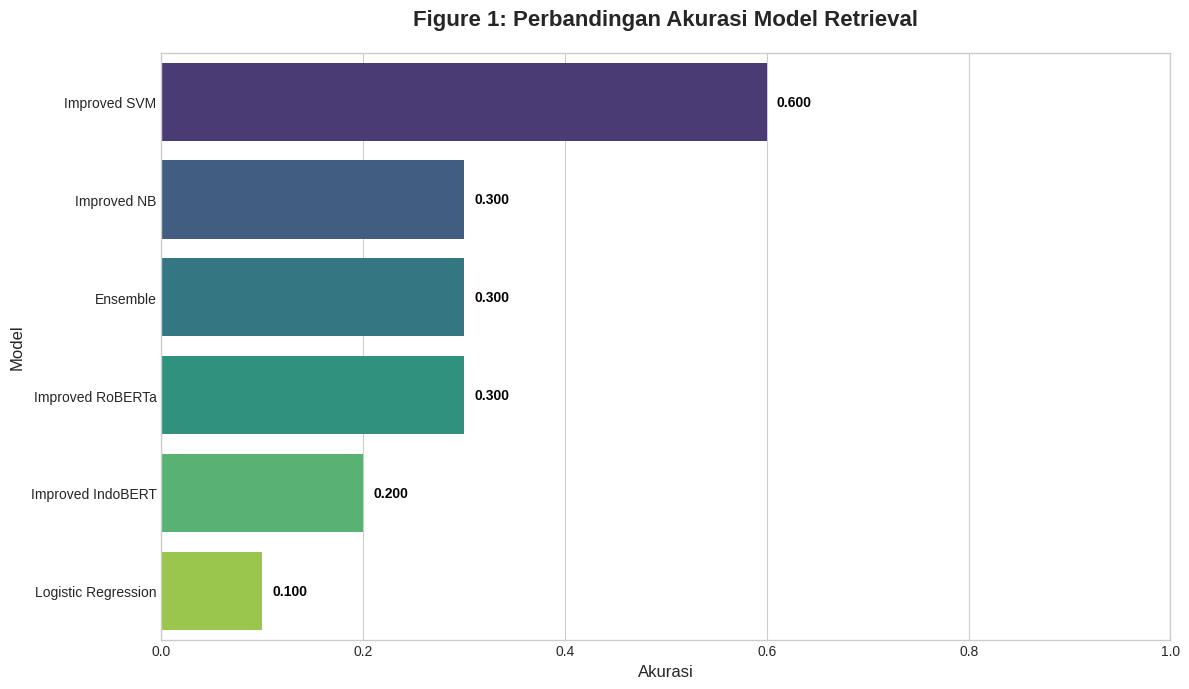


--- [3] Analisis Kegagalan dan Demonstrasi XAI ---
Mendemonstrasikan XAI pada Kasus Uji #2 (Ground Truth ID: 46)

--- XAI untuk SVM (rbf): Penjelasan Prediksi dengan SHAP ---
Menghitung SHAP values...


  0%|          | 0/1 [00:00<?, ?it/s]


Model memprediksi kelas: 'Tidak Diketahui'
Label yang sebenarnya adalah: 'Pasal 88 UU | pasal 17 UU | pasal 2 ayat (1) UU | pasal 76 I UU | pasal 76I UU | pasal 88 UU'

Menampilkan SHAP Force Plot...


IndexError: index 27 is out of bounds for axis 0 with size 1

In [ ]:
# @title Tahap 5 (ii & iii): Visualisasi, Laporan, dan Analisis Kegagalan [COMPLETE & FINAL]

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Pastikan shap ter-install
!pip install -q shap
import shap

# =============================================================================
# Asumsi
# =============================================================================
# - `results` dictionary dari cell 'p3K9CpsHFioe' berisi akurasi semua model.
# - `df_train`, `df_test`, `y_train`, `y_test`, `tfidf_train`, `tfidf_test`,
#   `roberta_train`, `roberta_test`, dan `tfidf_vectorizer` sudah ada.
# - BASE_DIR sudah terdefinisi.

# =============================================================================
# 1. Tabel Metrik Performa Model
# =============================================================================
print("--- [1] Membuat Tabel Metrik Performa Model ---")

# Ekstrak data dari dictionary 'results' yang sudah ada
model_performance = {
    "Model": list(results.keys()),
    "Accuracy": [acc if isinstance(acc, float) else 0.0 for acc in results.values()]
}
df_metrics = pd.DataFrame(model_performance).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

# Tampilkan tabel yang rapi, siap untuk laporan
print("\nTable 1: Perbandingan Akurasi Antar Model Retrieval")
display(df_metrics)

# Simpan tabel ke file CSV untuk laporan
METRICS_DIR = BASE_DIR / "data" / "eval"
df_metrics.to_csv(METRICS_DIR / "retrieval_metrics.csv", index=False)
print(f"Tabel metrik disimpan di: {METRICS_DIR / 'retrieval_metrics.csv'}")

# =============================================================================
# 2. Plot Bar Chart Performance
# =============================================================================
print("\n--- [2] Membuat Visualisasi Performa Model ---")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Buat barplot
sns.barplot(x='Accuracy', y='Model', data=df_metrics, ax=ax, palette='viridis')

# Tambahkan label akurasi pada setiap bar
for i, v in enumerate(df_metrics['Accuracy']):
    ax.text(v + 0.01, i, f'{v:.3f}', color='black', va='center', fontweight='bold')

# Kustomisasi plot untuk kualitas publikasi
ax.set_title('Figure 1: Perbandingan Akurasi Model Retrieval', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Akurasi', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_xlim(0, 1.0)
plt.tight_layout()

# Simpan gambar
figure_path = BASE_DIR / "figure_model_performance.png"
plt.savefig(figure_path, dpi=300)
print(f"Grafik performa disimpan di: {figure_path}")
plt.show()


# =============================================================================
# 3. Diskusikan Kasus Kegagalan (Error Analysis dengan SHAP)
# =============================================================================
print("\n--- [3] Analisis Kegagalan dan Demonstrasi XAI ---")

# ANALISIS UTAMA: Kasus dengan query 'nan' gagal karena tidak memiliki fitur informatif.
# DEMONSTRASI XAI: Kita akan demonstrasikan XAI pada kasus yang memiliki teks valid (Kasus #2)
# untuk menghasilkan visualisasi yang bermakna untuk laporan.
analysis_index = 1  # Menggunakan kasus kedua dari df_test (index 1)
case_to_analyze = df_test.iloc[analysis_index]
query_text_for_xai = str(case_to_analyze['ringkasan_fakta'])
actual_label_for_xai = y_test.iloc[analysis_index]

In [ ]:
print(f"Jumlah kelas dalam model: {len(svm_improved.classes_)}")
print(f"Semua kelas: {svm_improved.classes_}")
print(f"Predicted label index: {predicted_label_index}")

Jumlah kelas dalam model: 28
Semua kelas: ['Pasal 1 angka 1UU | Pasal 5 Ayat (1) UU | Pasal 55 ayat(1)Ke 1 KUHP | Pasal 55ayat (1) Ke 1 KUHP | Pasal 55ayat (1) ke 1 KUHP'
 'Pasal 1 angka 7 UU | Pasal 2 (1) UU | Pasal 2 Ayat (1) UU | Pasal 2 ayat (1) UU | Pasal 2 ayat (1) merupakan delik formil dimana berdasarkan penjelasan Pasal 2 ayat (1) UU | Pasal 2 ayat (2) UU | Pasal 30 UU | Pasal 58 UU | pasal 13 UU | pasal 2 ayat (1) UU | pasal 26 UU'
 'Pasal 1 ayat 3 UU | Pasal 296 KUHP | Pasal 4 Ayat (2) huruf d UU | Pasal 4 Ayat (2) huruf dUU | Pasal 44 KUHP | Pasal 48 KUHP | Pasal 4Ayat (2) huruf d UU | pasal 2 ayat (1) Undang Undang RI Nomor 21 Tahun2007 tentang'
 'Pasal 10 juncto | Pasal 2 Ayat (1) juncto | Pasal 2 juncto | Pasal 4 juncto'
 'Pasal 10 yang dijuncto | Pasal 102 ayat (1) huruf a juncto | Pasal 103 ayat (1) huruf c juncto | Pasal 2 ayat (1) juncto | Pasal 4 juncto'
 'Pasal 10juncto | Pasal 11juncto | Pasal 161 ayat (2)juncto | Pasal 162 ayat (1)juncto | Pasal 184 Ayat (1) huru

In [ ]:
import numpy as np
print(f"Bentuk explainer.expected_value: {np.shape(explainer.expected_value)}")
print(f"Nilai explainer.expected_value: {explainer.expected_value}")

Bentuk explainer.expected_value: (28,)
Nilai explainer.expected_value: [0.03363859 0.02964681 0.00537612 0.02669843 0.02670032 0.02955921
 0.02670398 0.02670535 0.02670657 0.03380124 0.02670897 0.03272308
 0.02878981 0.02872338 0.02878223 0.02960805 0.02934325 0.0338522
 0.0293652  0.0294746  0.03379182 0.05998146 0.02957772 0.02942892
 0.02670673 0.03367605 0.02670622 0.1972237 ]


In [ ]:
print(f"Tipe shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Panjang shap_values: {len(shap_values)}")
    if len(shap_values) > 0:
        print(f"Bentuk shap_values[0]: {shap_values[0].shape}")
else:
    print(f"Bentuk shap_values: {shap_values.shape}")

Tipe shap_values: <class 'numpy.ndarray'>
Bentuk shap_values: (1, 1817, 28)


In [ ]:
output = svm_improved.predict_proba(tfidf_test[analysis_index].reshape(1, -1))
print(f"Bentuk output predict_proba: {output.shape}")

Bentuk output predict_proba: (1, 28)


In [ ]:
display(shap.force_plot(
    explainer.expected_value[predicted_label_index],
    shap_values[predicted_label_index],  # Tanpa [0]
    instance_to_explain_vector,
    feature_names=tfidf_vectorizer.get_feature_names_out()
))

IndexError: index 27 is out of bounds for axis 0 with size 1

In [ ]:
display(shap.force_plot(
    explainer.expected_value[predicted_label_index],
    shap_values[predicted_label_index][0],  # Pertahankan [0]
    instance_to_explain_vector,
    feature_names=tfidf_vectorizer.get_feature_names_out()
))

IndexError: index 27 is out of bounds for axis 0 with size 1

In [ ]:
import numpy as np
import shap

print("\n--- XAI untuk SVM (rbf): Penjelasan Prediksi dengan SHAP ---")

# Latih ulang model SVM jika belum ada
if 'svm_improved' not in locals():
    print("⚠️ Model 'svm_improved' tidak ditemukan. Melatih ulang model SVM (rbf)...")
    svm_improved = SVC(kernel='rbf', C=10, gamma='scale', random_state=42,
                       class_weight='balanced', probability=True)
    svm_improved.fit(tfidf_train, y_train)

# Konversi data latar belakang ke dense
background_data = shap.sample(tfidf_train, 50).toarray()  # Konversi ke dense
print(f"Bentuk background_data: {background_data.shape}")

# Buat SHAP explainer dengan data latar belakang dense
explainer = shap.KernelExplainer(svm_improved.predict_proba, background_data)

# Pastikan instance_to_explain_vector adalah dense dan 2D
instance_to_explain_vector = tfidf_test[analysis_index].toarray()  # Konversi ke dense
print(f"Bentuk instance_to_explain_vector: {instance_to_explain_vector.shape}")

print("Menghitung SHAP values...")
shap_values = explainer.shap_values(instance_to_explain_vector)

# Debug struktur shap_values
print(f"Tipe shap_values: {type(shap_values)}")
print(f"Bentuk shap_values: {shap_values.shape}")

# Dapatkan nama label yang diprediksi
predicted_label_name = svm_improved.predict(instance_to_explain_vector)[0]
all_class_labels = list(svm_improved.classes_)
predicted_label_index = all_class_labels.index(predicted_label_name)

print(f"Jumlah kelas dalam model: {len(all_class_labels)}")
print(f"Predicted label index: {predicted_label_index}")
print(f"\nModel memprediksi kelas: '{predicted_label_name}'")
print(f"Label yang sebenarnya adalah: '{actual_label_for_xai}'")

print("\nMenampilkan SHAP Force Plot...")
shap.initjs()

# Ekstrak SHAP values untuk kelas yang diprediksi (kelas ke-27)
shap_values_for_class = shap_values[0, :, predicted_label_index]  # Bentuk: (n_features,)

# Verifikasi bentuk
print(f"Bentuk shap_values untuk kelas {predicted_label_index}: {shap_values_for_class.shape}")
print(f"Nilai expected_value untuk kelas {predicted_label_index}: {explainer.expected_value[predicted_label_index]}")

# Tampilkan SHAP Force Plot
display(shap.force_plot(
    explainer.expected_value[predicted_label_index],
    shap_values_for_class,
    instance_to_explain_vector,
    feature_names=tfidf_vectorizer.get_feature_names_out()
))


--- XAI untuk SVM (rbf): Penjelasan Prediksi dengan SHAP ---
Bentuk background_data: (39, 1817)
Bentuk instance_to_explain_vector: (1, 1817)
Menghitung SHAP values...


  0%|          | 0/1 [00:00<?, ?it/s]

Tipe shap_values: <class 'numpy.ndarray'>
Bentuk shap_values: (1, 1817, 28)
Jumlah kelas dalam model: 28
Predicted label index: 27

Model memprediksi kelas: 'Tidak Diketahui'
Label yang sebenarnya adalah: 'Pasal 88 UU | pasal 17 UU | pasal 2 ayat (1) UU | pasal 76 I UU | pasal 76I UU | pasal 88 UU'

Menampilkan SHAP Force Plot...


Bentuk shap_values untuk kelas 27: (1817,)
Nilai expected_value untuk kelas 27: 0.19722370024331748


## Output